<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br> <h2> Modeling Case Study</h2>
<h4>DAT-5329 | Introduction to Machine learning & Ai </h4>
Ester Van de Put <br>
Hult International Business School<br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h3>Introduction</h3><br>
<hr style="height:.7x;border:none;color:#333;background-color:#333;" /><br>
This regression modeling case study focuses on developing a predictive model to analyze and forecast birthweight, a critical determinant of neonatal health and future development. Pregnancy is a crucial phase where the baby's health is paramount to both parents and healthcare professionals. Among various health indicators monitored during this period, birthweight is a vital sign of a newborn's well-being. Deviations from the normal weight range can indicate potential health issues, prompting the need for early intervention.

Public health researchers tirelessly work to uncover and mitigate factors leading to adverse birth outcomes, aiming to enhance the understanding of birthweight's implications. This endeavor seeks to ensure that pregnancies are as healthy as possible, culminating in the birth of thriving infants.

In this comprehensive case study, I will delve into the intricate relationships between various factors and birthweight. The objective is to navigate the complexities of birthweight-related outcomes and establish a predictive model that could serve as a proactive tool in healthcare management. This model aims to make it easier for professionals to identify pregnancies at risk of resulting in low birthweight infants and, therefore, enable precise, targeted interventions.

This analysis aims to create a sophisticated predictive model encompassing the various factors and dynamics affecting birthweight. By understanding factors such as genetic predispositions, environmental influences, and maternal health, this model aims to empower healthcare professionals and parents with actionable insights. Consequently, this will improve prenatal care strategies and interventions, potentially decreasing the incidence of low birthweight and associated health complications.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part I: Imports and Data Check</h2>

In [1]:
## importing libraries ##

# standard libraries
import numpy as np # mathematical essentials
import pandas  as pd  # data science essentials
import matplotlib.pyplot as plt # graphical output
import seaborn as sns # enhancing graphical output

# classficiation libraries
import phik #phi coefficient
import sklearn.linear_model # linear models
import statsmodels.formula.api as smf # predictive modeling 

# preprocessing and testing
from sklearn.preprocessing import power_transform    # yeo-johnson
from sklearn.preprocessing import StandardScaler     # standard scaler
from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import (confusion_matrix,
                             roc_auc_score, precision_score, recall_score)
from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV, GridSearchCV) # train/test split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler


#!###############################!#
#!# import additional libraries #!#
#!###############################!#


from datetime import datetime # to show date and time
import sklearn.neighbors # import neighbors
from sklearn.impute import SimpleImputer # to handle missing values in the data
import sklearn.tree # import tree module

import warnings # manages warnings
from sklearn.exceptions import FitFailedWarning # catches warnings related to failures during fitting process
warnings.filterwarnings('ignore') # ignore warnings to keep the output clean and uncluttered


# setting pandas print options (optional)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<br>

In [2]:
## Importing data ##

# Upload and read excel data into a DataFrame.
file ="./birthweight.xlsx"

# Naming the DataFrame as df_train
df_train = pd.read_excel(io=file, 
                      header = 0, 
                      index_col = 'obs_id') #setting 'obs_id' as the index column.


# Upload the testing dataset from a csv file into a DataFrame.
testing_data = './kaggle_test_data.csv'

# Naming the DataFrame as df_test
df_test = pd.read_csv (filepath_or_buffer = testing_data,
                        header     = 0,
                        index_col  = 'obs_id') #setting 'obs_id' as the index column.

**Creating and Defining the User-defined functions for the analysis** 

In [3]:
###############################
# standard_scaler
###############################

def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)
    
    # FITTING the scaler with the data
    scaler.fit(df)

    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)

    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

###############################
## visual_cm
###############################

def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)
    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()

#########################
# mv_flagger
#########################
def mv_flagger(df):
    """
Flags all columns that have missing values with 'm-COLUMN_NAME'.

PARAMETERS
----------
df : DataFrame to flag missing values


RETURNS
-------
DataFrame with missing value flags."""


    for col in df:

        if df[col].isnull().astype(int).sum() > 0:
            df['m_'+col] = df[col].isnull().astype(int)
            
    return df


#########################
# text_split_feature
#########################
def text_split_feature(col, df, sep=' ', new_col_name='number_of_names'):
    """
Splits values in a string Series (as part of a DataFrame) and sums the number
of resulting items. Automatically appends summed column to original DataFrame.

PARAMETERS
----------
col          : column to split
df           : DataFrame where column is located
sep          : string sequence to split by, default ' '
new_col_name : name of new column after summing split, default
               'number_of_names'
"""
    
    df[new_col_name] = 0
    
    
    for index, val in df.iterrows():
        df.loc[index, new_col_name] = len(df.loc[index, col].split(sep = ' '))
        
        
########################################
# plot_feature_importances
########################################
def plot_feature_importances(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = train.shape[1]
    
    # setting plot window
    fig, ax = plt.subplots(figsize=(12,9))
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('./analysis_images/Feature_Importance.png')

<br>

In [4]:
# Concatenating datasets together for mv analysis and feature engineering.
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

# Concatenating both datasets together for mv and feature engineering.
df_full = pd.concat(objs = [df_train, df_test],
                    axis = 0,
                    ignore_index = False)


# Checking data.
df_full.head(n = 5)

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set
obs_id,,,,,,,,,,,,,,,,,,,
id_0001,33,12.0,1.0,5.0,31.0,11.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,360.0,Not Kaggle
id_0002,30,14.0,2.0,6.0,31.0,14.0,4.0,6.0,0.0,0.0,0,1,0,0,1,0,0,506.0,Not Kaggle
id_0003,28,14.0,1.0,7.0,29.0,16.0,2.0,5.0,0.0,0.0,0,1,0,0,1,0,0,680.0,Not Kaggle
id_0005,26,NaN,5.0,2.0,21.0,NaN,4.0,7.0,0.0,0.0,1,0,1,0,0,1,0,697.0,Not Kaggle
id_0006,31,16.0,2.0,5.0,32.0,16.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,737.0,Not Kaggle


<br>

In [5]:
# Checking available features in the df_full.
df_full.columns

Index(['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set'], dtype='object')

<br>

In [6]:
#!##############################!#
#!# set your response variable #!#
#!##############################!#
y_variable = 'low_bwght' # this should be a string

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<hr style="height:.7x;border:none;color:#333;background-color:#333;" /><br>

<h2>  Part II: Data Preparation & Descriptive Analysis </h2>
<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>
<h3> (1) Descriptive Analysis</h3>

This section delves into the dataset, offering better insights into the training, testing, and overall data. We start by examining the dataset's size, the variety of data types it includes, and any missing values. 

A key part of our analysis involves looking at descriptive statistics for each feature, including means, standard deviations, minimums, and maximums, which will provide us with a better picture of how the data is distributed and the scale of each feature.

Through this process, if any aspect seems particularly intriguing, we will investigate further to uncover patterns that could be helpful to the creation of our model. 

### 1.1. Feature Descriptions

The table below describes each feature included in the dataset. 
I included this description to ensure clarity and facilitate understanding of the variables at play in the predictive model. 

| Feature Number | Label | Description |
|----------------|-------|-------------|
| 1 | `mage` | Mother's age in years |
| 2 | `meduc` | Mother's education in years |
| 3 | `monpre` | Month of pregnancy prenatal care began |
| 4 | `npvis` | Total prenatal visits |
| 5 | `fage` | Father's age in years |
| 6 | `feduc` | Father's education in years |
| 7 | `omaps` | One minute Apgar score |
| 8 | `fmaps` | Five minute Apgar score |
| 9 | `cigs` | Avg. cigarettes/day by mother |
| 10 | `drink` | Avg. drinks/week by mother |
| 11 | `male` | 1 if baby is male |
| 12 | `mwhte` | 1 if mother is white |
| 13 | `mblck` | 1 if mother is black |
| 14 | `moth` | 1 if mother is neither black nor white |
| 15 | `fwhte` | 1 if father is white |
| 16 | `fblck` | 1 if father is black |
| 17 | `foth` | 1 if father is neither black nor white |
| 18 | `bwght` | Birthweight in grams |


In [7]:
# Displaying the first 5 rows of the DataFrame df_test to analyze the initial data

df_full.head(n=3) # Set limit to 3 to avoid datadumping.

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set
obs_id,,,,,,,,,,,,,,,,,,,
id_0001,33,12.0,1.0,5.0,31.0,11.0,NaN,NaN,0.0,0.0,1,1,0,0,1,0,0,360.0,Not Kaggle
id_0002,30,14.0,2.0,6.0,31.0,14.0,4.0,6.0,0.0,0.0,0,1,0,0,1,0,0,506.0,Not Kaggle
id_0003,28,14.0,1.0,7.0,29.0,16.0,2.0,5.0,0.0,0.0,0,1,0,0,1,0,0,680.0,Not Kaggle


In [8]:
# Displaying detailed information about the DataFrame df_full,
# Including the variable dtype, the columns name, non-null counts

df_full.info(verbose=True) #  Setting 'Verbose' to True to ensure all column information are printed. 

<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, id_0001 to id_0302
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mage    1832 non-null   int64  
 1   meduc   1802 non-null   float64
 2   monpre  1827 non-null   float64
 3   npvis   1764 non-null   float64
 4   fage    1826 non-null   float64
 5   feduc   1785 non-null   float64
 6   omaps   1829 non-null   float64
 7   fmaps   1829 non-null   float64
 8   cigs    1722 non-null   float64
 9   drink   1717 non-null   float64
 10  male    1832 non-null   int64  
 11  mwhte   1832 non-null   int64  
 12  mblck   1832 non-null   int64  
 13  moth    1832 non-null   int64  
 14  fwhte   1832 non-null   int64  
 15  fblck   1832 non-null   int64  
 16  foth    1832 non-null   int64  
 17  bwght   1648 non-null   float64
 18  set     1832 non-null   object 
dtypes: float64(10), int64(8), object(1)
memory usage: 286.2+ KB


In [9]:
# Generating descriptive statistics of the Dataframe df_full
# including count, mean, standard deviaition, minimum and maximum values. 

# Generating the descriptive statistics only for numeric data
df_train_stats = df_train.iloc[ :, : ].describe(include = 'number').round(decimals =2) # rounding decimals
# checking results
df_train_stats

,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght
count,1648.00,1623.00,1644.00,1592.00,1642.00,1611.00,1645.00,1645.00,1547.00,1543.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00
mean,29.52,13.74,2.13,11.60,31.87,13.92,8.39,9.00,1.13,0.02,0.52,0.88,0.06,0.05,0.89,0.06,0.05,3405.56
std,4.76,2.09,1.26,3.74,5.66,2.26,1.11,0.48,4.34,0.30,0.50,0.32,0.24,0.23,0.32,0.24,0.22,576.12
min,16.00,3.00,0.00,0.00,18.00,3.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,360.00
25%,26.00,12.00,1.00,10.00,28.00,12.00,8.00,9.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,3080.00
50%,29.00,14.00,2.00,12.00,31.00,14.00,9.00,9.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3430.00
75%,32.25,16.00,2.00,12.25,35.00,16.00,9.00,9.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3770.00
max,44.00,17.00,9.00,40.00,62.00,17.00,10.00,10.00,40.00,8.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5204.00


### 1.2. Dropping unnecessary columns

In [10]:
# dropping post-event horizon features
df_full = df_full.drop(labels = ["omaps","fmaps"],
                         axis   = 1)

# checking results
df_full.columns

Index(['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set'], dtype='object')

<br><br>
<h3>(2) Base Modeling</h3>

In [11]:
## Base Modeling ##

# Initial exploration to determine the dataset size.
# Printing the number of obersations (row) and feature (column) in df_full.

# Formatting and printing the dimensions of the full dataset.

print(f"""
Size of Original Dataset
------------------------
Observations (rows): {df_full.shape[0]}
Features (columns) : {df_full.shape[1]}
""")


Size of Original Dataset
------------------------
Observations (rows): 1832
Features (columns) : 17



### (3) Correlation Matrix with Birthweight

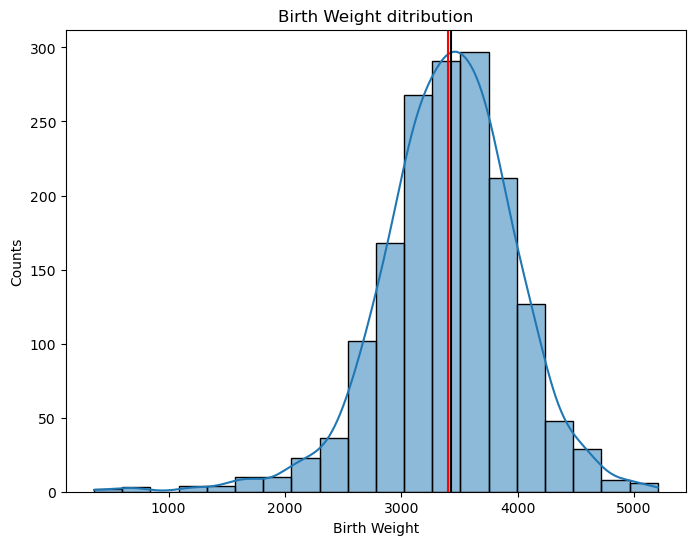

In [12]:
# Develop a histogram with HISTPLOT to visualize the distribution of 'bwght' 

# Set the histogram figure size.
plt.figure(figsize = (8,6))


sns.histplot(data = df_full['bwght'],
             bins = 20,
             kde = True)# KDE added for smooth distribution curve.

# Adding title and axis labels to the graph 
plt.title (label = 'Birth Weight ditribution') 
plt.xlabel (xlabel = 'Birth Weight') # avoiding using dataset labels
plt.ylabel (ylabel = 'Counts')

# lines of "mean"
plt.axvline(df_train["bwght"].mean(),  # "AXis Vertical, LINE" = "axvline"
            color="red")
# lines of "median"
plt.axvline(df_train["bwght"].median(),  
            color="black")

# Display the histogram to visualize the distribution. 
plt.show()

In [13]:
# Correlation pearson within the babies dataset
df_full_corr = df_full.corr (method = 'pearson', 
                              numeric_only = True). round(decimals=2)

# checking results
df_full_corr.loc[:,'bwght'].sort_values(ascending = False)

bwght     1.00
npvis     0.10
fage      0.07
male      0.07
fwhte     0.07
feduc     0.05
mwhte     0.05
meduc     0.04
mage      0.03
monpre   -0.00
drink    -0.02
mblck    -0.02
fblck    -0.02
moth     -0.05
foth     -0.07
cigs     -0.09
Name: bwght, dtype: float64

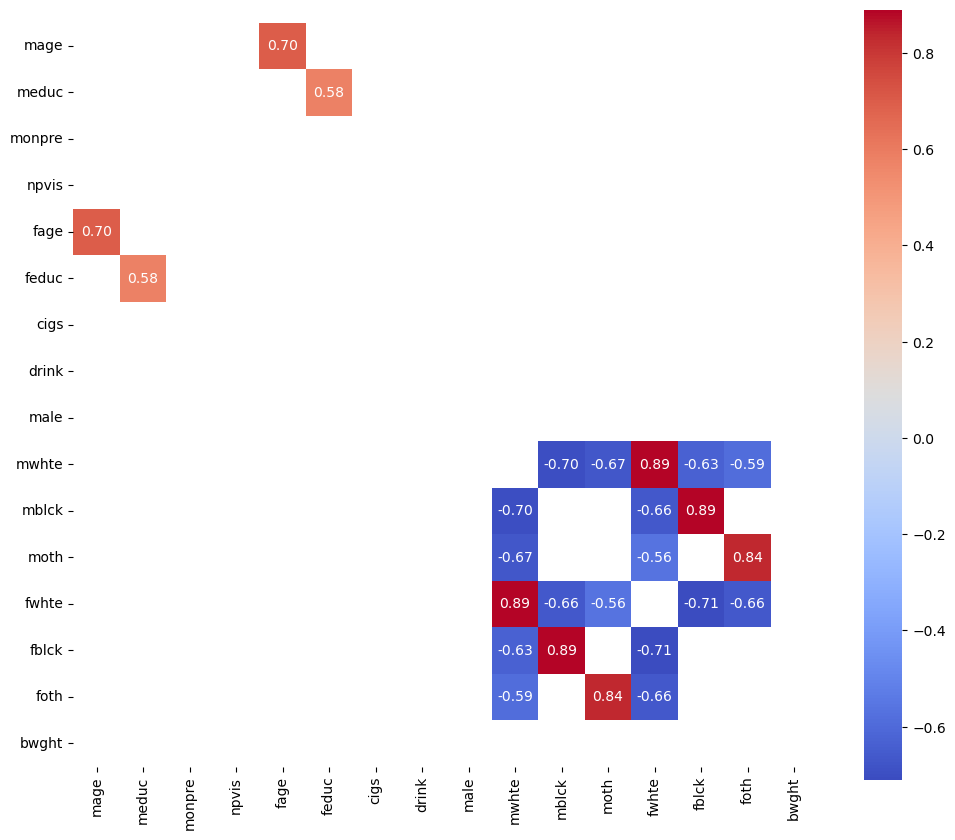

In [14]:
## Visualizing the correlation matrix ##

# Set the figure size for the heatmap.
plt.figure(figsize=(12, 10))

# Calculate the correlation matrix for numerical columns ONLY in df_full to analyze the inter-variables relationship.
corr = df_full.corr(numeric_only=True).round(decimals=2)

# To avoid data dumping: 

# (1) Create a mask for correlations greater than 0.5 in absolute value
high_corr_mask = abs(corr) > 0.5

# (2) Adjust the mask to also exclude correlations of exactly 1
final_mask = high_corr_mask & (corr != 1) 

# Creating a heatmap to visualize the important correlations with the mask applied.
# Using the 'final_mask' to exclude both: correlations of 1 and those below the absolute value of 0.5
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, mask=~final_mask)

# Display the visualization.
plt.show()

## Based on this initial correlation analysis, here are the main insights I gathered:

**Strong correlations:**

- Intergenerational Health: A notable correlation (0.70) exists between the mother's (mage) and father's (fage) ages, reflecting common patterns where partners are often close in age. This trend aligns with research indicating that advanced parental age can be associated with increased risk of complications, which can influence a newborn's weight (Wang. et al, 2020). 


- Educational Pairing: Parents' education levels also correlate significantly (meduc and feduc with a correlation of 0.58), indicating educational homogamy. This relation could reflect broader socioeconomic patterns influencing family health behaviors and prenatal care decisions.

- Racial Homogeneity: High correlations between the race of the mother and father (mwhte with fwhte, and mblck with fblck, both at 0.89) point towards racial homogeneity in pairings, which may have socioeconomic and cultural implications for birthweight outcomes.

- Maternal Habits and Prenatal Health: While smoking (cigs) did not exceed the 0.5 threshold for strong correlation with birth weight (bwght), its clinical significance in prenatal health is well-established and warrants further investigation despite a lower correlation in this particular dataset.

**Lesser but noteworthy correlations :**

- Prenatal Care: The analysis also revealed a correlation between increased prenatal visits (npvis) and the start of prenatal care (monpre) with birth weights, suggesting that access to and utilization of prenatal care can positively influence the health of newborns. However, it's important to approach these findings with caution. The frequency of prenatal visits and the timing of care initiation can be influenced by various factors, including the parents' age and socioeconomic status, such as wealth and access to healthcare (Alexander & Korenbrot, 1995).

- Parental Age and Education's Subtle Influence: Oppositely to my assumptions, parental ages (mage, fage) and mothers' education (meduc) demonstrated weaker correlations with birth weight. This nuanced finding suggests that age and education, in isolation, might not be as influential on birth weight as previously thought within the dataset.

- Maternal Alcohol Consumption's Ambiguous Role: Maternal drinking habits (drink) showed a negligible correlation with birth weight, presenting an ambiguous picture, which implies that within the dataset's range, maternal alcohol consumption doesn't play a significant role in influencing birth weight, or the data does not capture the full spectrum of drinking behaviors.

In [15]:
# Used the statsmodels package for linear regression analysis.

# (1) Instantiate a model object with specific features to predict 'RENTALS'.
# Used 'ols' method to evaluate the relationship between 'RENTALS' and different features.
lm_best = smf.ols(formula="""bwght ~ npvis +
                                fage +
                                male +
                                fwhte +
                                feduc +
                                mwhte +
                                mage +
                                monpre +
                                drink +
                                mblck +
                                fblck +
                                moth +
                                foth +
                                cigs""",
                  data=df_full)


# (2) Fitting the model with the dataset.
# This will compute the best-fitting line for predicting 'RENTALS' from the features I selected.
results = lm_best.fit()

# (3) analyze the SUMMARY output of the model fit.
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  bwght   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.288
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           1.03e-06
Time:                        20:41:51   Log-Likelihood:                -11323.
No. Observations:                1461   AIC:                         2.267e+04
Df Residuals:                    1448   BIC:                         2.274e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1658.0538     88.628     18.708      0.0

**Insights from OLS Regression Analysis:**

- Prenatal Visits (**npvis**): Positive relationship between the number of prenatal visits and birth weight, suggesting that increased prenatal care is associated with higher birth weights. This could be due to improved health monitoring and access to healthcare during pregnancy.

- Male Babies (**male**): Positive coefficient, indicating that, on average, male babies tend to have a higher birth weight than female babies. 

- Parental Race (fwhte, mwhte, mblck, fblck): Both parents being white (**fwhte, mwhte**) or black (**mblck, fblck**) show positive coefficients. This might reflect underlying socioeconomic, genetic, or healthcare access differences. The substantial coefficients for parents identified as black may underline a complex interplay of factors that would affect birth weight, which would be interesting to analyze further.  

- Mother's Pre-pregnancy Education (**feduc**) and Father's Age (**fage**): These variables show a positive but not statistically significant relationship with birth weight, indicating that while there might be an association, further research is needed to confirm these findings.

- Mother's Age (**mage**): The analysis indicates a negligible and statistically insignificant effect of the mother's age on birth weight, suggesting that other factors not captured in this model might be more influential in determining birth weight.

- **Monpre** (Month Prenatal Care Began): Starting prenatal care earlier is positively associated with birth weight, reinforcing the importance of early and consistent prenatal care. 

- Smoking Habits (**cigs**): As expected, smoking has a negative impact on birth weight, aligning with the extensive literature on the adverse effects of maternal smoking on fetal development (CDC, n.d.).

- Mother's Race (**moth**) and Father's Race (**foth**) other than Black or White: These variables show positive coefficients, indicating a complex relationship between parental race and birth weight that may involve socioeconomic and healthcare access factors.


Overall, the low R-squared value suggests that while the factors analyzed contribute to variations in birth weight, a significant portion of the variability remains unexplained by this model. This highlights the complexity of factors influencing birth weight, including genetic, environmental, socioeconomic, and healthcare-related issues, and emphasizes the need to further our research (by adding other features) to be able to 'grasp' a better picture of 'birth weight' and ultimately build a more robust predictive model. 

### 1.4. Deeper initial Analysis of my data based on assumption

Checking for the demographics of my data as a pre-analysis of my data to better understand my dataset. I will check for boys vs girls birth ratio, the race, the female age, and other. My hope is to bget better insights to know what to look at. 

**(1) Babies' Gender Ratio in Dataset**

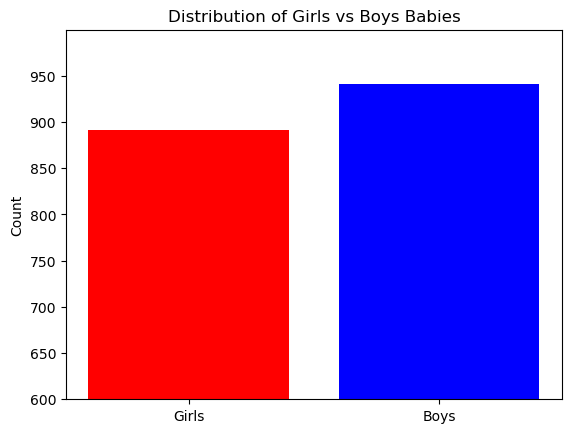

In [16]:
### (1) Checking Boys vs Girl ratio in babies birth in my data 

# Male column, indicating 1 for male (boys)

# Dividing my data into boys and girls based on 'male' feature
boys_data = df_full[df_full['male'] == 1]['male']
girls_data = df_full[df_full['male'] == 0]['male']

# Plotting the distribution of girls vs boys using a bar chart
plt.bar([0, 1], [len(girls_data), len(boys_data)], color=['red', 'blue'])

# Adding titles and labels:
plt.title('Distribution of Girls vs Boys Babies')
plt.ylabel('Count')
plt.xticks([0, 1], ['Girls', 'Boys'])
plt.ylim(600, 1000) # Sets the limits of the y-axis to range from 600 to 1000
plt.yticks(range(600, 1000, 50)) #Sets the tick marks on the y-axis at 50, starting from 600 to 1000

# Display the visualization:
plt.show()

**Insights:**

The bar chart illustrates the gender distribution of newborns in the dataset, with a nearly equal count of girls (red bar) and boys (blue bar). This even distribution implies that the dataset does not exhibit a gender bias, which will be beneficial when analyzing birth weight across a gender-balanced sample. For this analysis, which is focused on factors affecting birth weight, the balanced gender proportion allows me to consider and compare the impact of prenatal factors without the confounding effect of a skewed gender ratio. Thus, any differences I will observe in birth weight outcomes between girls and boys can be investigated without concerns of underlying sample bias due to gender distribution.

**(2)Race ratio within the dataset**

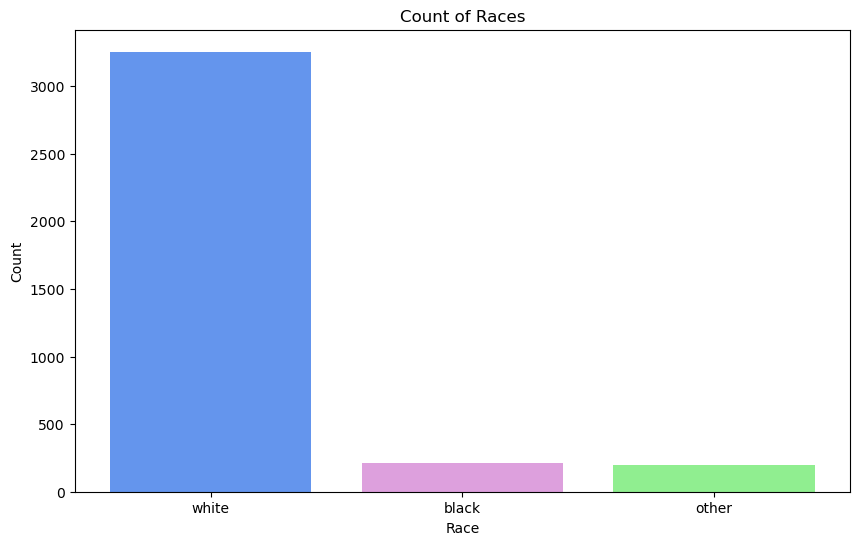

In [17]:
### (2) Checking the race ratio within my dataset. 
# knowing there is white, black and other in our dataset
# Aggregating the counts for 'white', 'black', and 'other' across both males and females

# Aggregate counts for each race across both genders
white_count = df_full[['mwhte', 'fwhte']].sum().sum()
black_count = df_full[['mblck', 'fblck']].sum().sum()
other_count = df_full[['moth', 'foth']].sum().sum()

# Store the aggregated counts in a list for easy plotting
counts = [white_count, black_count, other_count]

# Define the races and indices 
races = ['white', 'black', 'other']
indices = range(len(races))

# Visualizing by plotting the result in a bar graph
plt.figure(figsize=(10, 6))
plt.bar(indices, counts, color=['cornflowerblue', 'plum', 'lightgreen'])

# Customize xticks to label the different races
plt.xticks(indices, races)

# Adding title and axis labels to the graph 
plt.title('Count of Races')
plt.xlabel('Race')
plt.ylabel('Count')

# Display the results
plt.show()

**Insights:**

This bar chart presents the racial distribution of the dataset, highlighting a significant majority of white individuals compared to black and other races. This demographic skew is critical to acknowledge as it suggests our dataset may only fully present all racial groups, and such a disparity must be considered during analysis since it's well-documented that race and demographics can influence newborn health outcomes (Office of Minority Health [OMH], n.d.). Therefore, our study's conclusions might be more reflective of the white population's birth trends and may not accurately capture the birthweight dynamics in other racial groups, potentially limiting the generalizability of our findings.

**(3) Maternal Smoking vs. Birthweight**

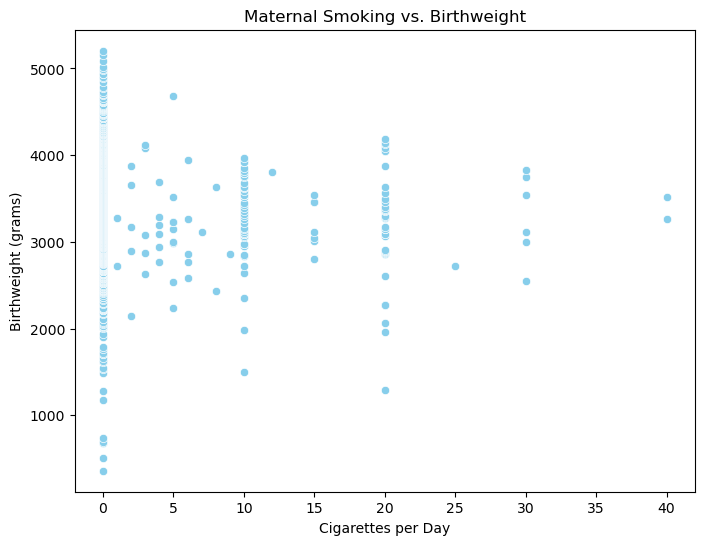

In [18]:
### (4)(2)Scatterplot to explore the correlation between maternal smoking and birthweight

# Set the histogram figure size.
plt.figure(figsize=(8, 6))

# Plotting a scatterplot to visualize the relationship between ‘cigs’ and ‘bwght’ 
sns.scatterplot(x='cigs', y='bwght', data=df_full, color='skyblue')

# Adding title and axis labels to the graph 
plt.title('Maternal Smoking vs. Birthweight')
plt.xlabel('Cigarettes per Day')
plt.ylabel('Birthweight (grams)')

# Display the histogram to visualize the distribution. 
plt.show()

**Insights:**

The scatter plot illustrates the relationship between maternal smoking and birth weight, showing varied birth weights across different levels of cigarette consumption. While there is no distinct pattern, the presence of lower birth weights at higher smoking levels aligns with known health risks; smoking is a well-documented risk factor for lower birth weights. The Centers for Disease Control and Prevention (CDC) notes that "One in every five babies born to mothers who smoke during pregnancy has low birth weight" (CDC, n.d.). This graph thus proves the broader public health understanding and supports the need for expecting mothers to stop smoking during pregnancy to promote healthier birth outcomes.

 **(4) Prenatal visit vs birth weight**

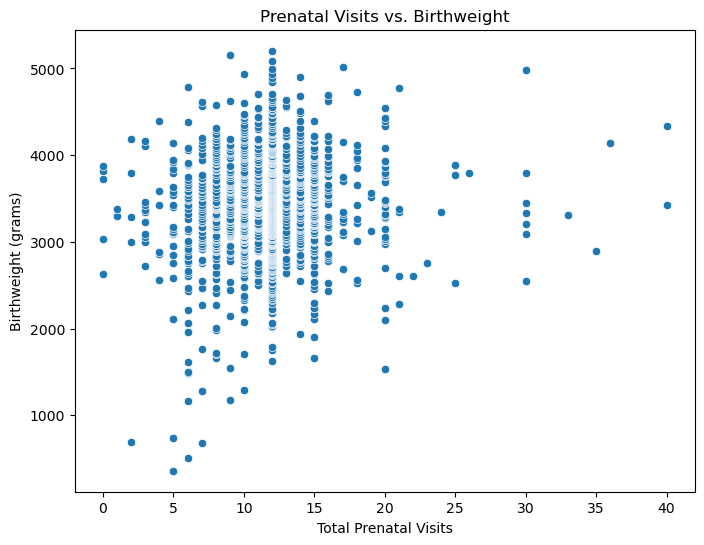

In [19]:
# Creating a Scatter plot for prenatal visits vs. birthweight

##Setting up the figure size for the plot
plt.figure(figsize=(8, 6))

# Plotting a scatterplot to visualize the relationship.
sns.scatterplot(x='npvis', y='bwght', data=df_full)

# Adding title and labels
plt.title('Prenatal Visits vs. Birthweight')
plt.xlabel('Total Prenatal Visits')
plt.ylabel('Birthweight (grams)')

# Displaying the graph
plt.show()

**Insights:**

The scatter plot shows the relationship between the total number of prenatal visits and birth weight in grams. The distribution of dots suggests that there isn't a robust and clear trend between more prenatal visits and higher birth weights, as the points are widely spread out. Most data points are clustered at the lower end of prenatal visits, which is expected since standard prenatal care schedules typically recommend a certain number of visits unless complications arise (Wang. et al., 2020). However, there are several outliers, particularly with higher birth weights spread across the range of prenatal visits, which shows that other factors may also play a significant role in determining birth weight. Additionally, no distinct cluster of points indicates a definitive pattern, underscoring the complexity of factors that influence birth weight.

<br><h2> Missing Value Analysis and Imputation</h2>

In [20]:
## Missing Value Imputation ##

# Checking for missing values in df_full to identify columns that require imputation.
df_full.isnull().sum(axis=0)

mage        0
meduc      30
monpre      5
npvis      68
fage        6
feduc      47
cigs      110
drink     115
male        0
mwhte       0
mblck       0
moth        0
fwhte       0
fblck       0
foth        0
bwght     184
set         0
dtype: int64

**Missing values found in the following features:**
    
- Mother's education in years (meduc):  30 missing values; continuous.  
- Month of pregnancy that prenatal care began (monpre) : 45missing values; discrete. 
- Total number of prenatal visits (npvis) 68 missing values; discrete. 
- Father's age in years (fage): 6 missing values, continuous. 
- Father's education in years (feduc): 47 missing values; continuous.
- Average cigarettes per day consumed by the mother (cigs): 110 missing values, discrete. 
- Average drinks per week consumed by the mother (drink): 115 missing values, discrete. 

**Before Handling missing values**

Creating a  frequency table for 'drink' and 'cigs' to understand the data better:

In [21]:
# frequency table for drink
df_full['drink'].value_counts()

drink
0.0    1701
1.0      11
2.0       2
6.0       1
5.0       1
8.0       1
Name: count, dtype: int64

In [22]:
# frequency table for cigs
df_full['cigs'].value_counts()

cigs
0.0     1575
10.0      50
20.0      39
5.0       11
4.0        7
15.0       7
30.0       6
6.0        6
2.0        5
3.0        5
40.0       2
8.0        2
1.0        2
12.0       1
25.0       1
7.0        1
9.0        1
16.0       1
Name: count, dtype: int64

After looking at these frequency table, and specifically at drinking habits, I believe there is not enough observation of pregnant women with weekly drinking habit inside the dataset to keep this feature in the daatset

In [23]:
# dropping "drink" feature
df_full = df_full.drop(labels = 'drink',
                       axis   = 1)

# Checking the remaining columns
df_full.columns

Index(['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set'], dtype='object')

<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<hr style="height:.7x;border:none;color:#333;background-color:#333;" /><br>

<h2>  Part II: Data Preparation & Descriptive Analysis </h2>
<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>
<h3> (1) Flagging Missing Values</h3>



In [24]:
# running the mv_flagger function
df_full = mv_flagger(df= df_full)


# checking results
df_full.columns

# Drop 'm_' prefixed columns except 'm_cigs' directly from the original DataFrame
df_full.drop(columns=[col for col in df_full.columns if col.startswith('m_')], inplace=True)

<h3> (2) Developing a Strategy for Missing Data Imputation Based on Feature Analysis </h3>

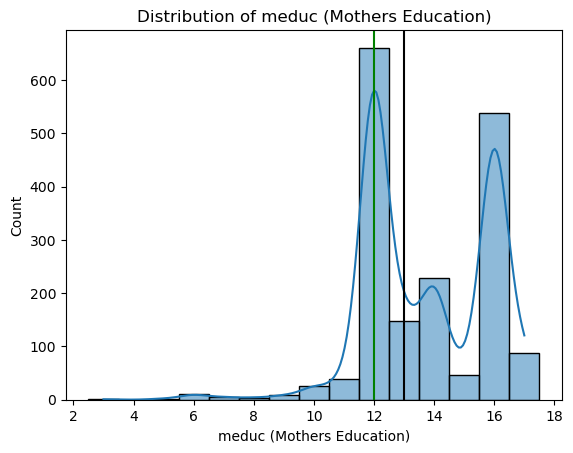

In [25]:
## (1) Missing Value Imputation of meduc (Mother's Education in Years) variable

# plotting 'meduc (Mother's Education) variable'
sns.histplot(x = 'meduc',
            data = df_full,
            kde = True, 
            binwidth=1,
            discrete=True)

# lines of "median"
plt.axvline(df_full["meduc"].median(),  
            color="black")
plt.axvline(df_full['feduc'].mode().iloc[0], color="green") 

# title and labels
plt.title (label  = 'Distribution of meduc (Mothers Education)')
plt.xlabel(xlabel = 'meduc (Mothers Education)')
plt.ylabel(ylabel = 'Count')

# displaying the plot
plt.show()

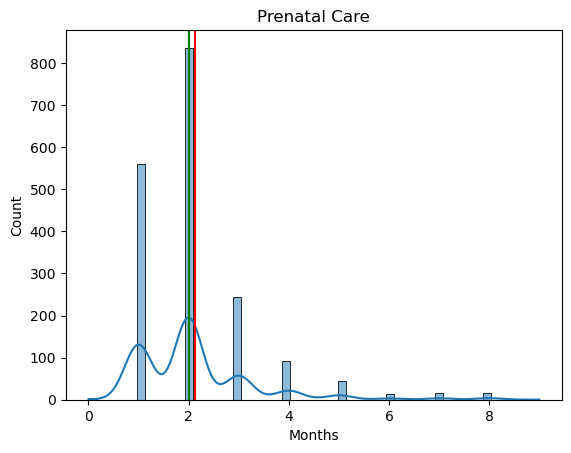

In [26]:
## (2) Missing Value Imputation of monpre (Month of pregnancy that Prenatal Care Began)

# Plotting 'monpre (Month of pregnancy that Prenatal Care Began)'
sns.histplot(x = 'monpre',
            data = df_full,
            kde = True)

# mean and median lines
plt.axvline(df_full['monpre'].mean(), color="red")
plt.axvline(df_full['monpre'].median(), color="blue")
plt.axvline(df_full['monpre'].mode().iloc[0], color="green") 

# title and labels
plt.title (label  = "Prenatal Care")
plt.xlabel(xlabel = 'Months')
plt.ylabel(ylabel = 'Count')


# displaying the plot
plt.show()

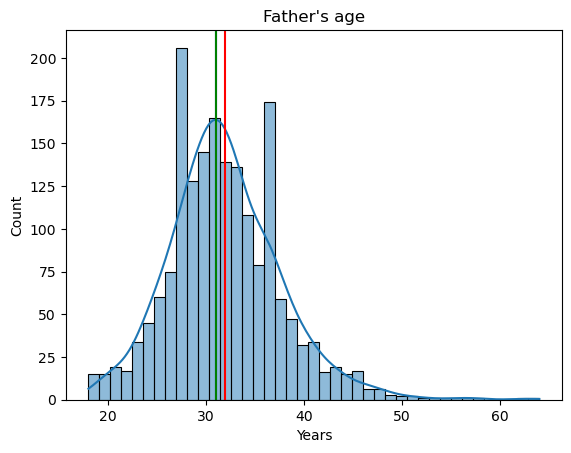

In [27]:
## (3) Missing Value Imputation of 'fage'(Father's Age in years) variable

# Plotting 'Father's age in years' into a HISTPLOT to decide on method on implantation
sns.histplot(x = 'fage',
            data = df_full,
            kde = True)

# mean and median lines
plt.axvline(df_full['fage'].mean(), color="red")
plt.axvline(df_full['fage'].median(), color="blue")
plt.axvline(df_full['fage'].mode().iloc[0], color="green") 


# title and labels
plt.title (label  = "Father's age")
plt.xlabel(xlabel = 'Years')
plt.ylabel(ylabel = 'Count')


# displaying the plot
plt.show()

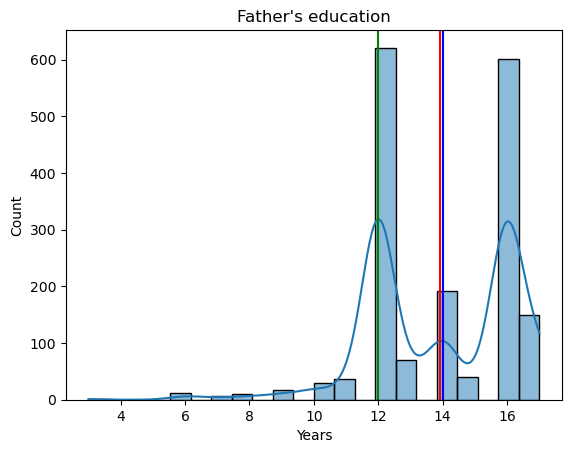

In [28]:
## (4) Missing Value Imputation of 'feduc'(Father's Education in Years) variable

# plotting 'Father's Education in Years'
sns.histplot(x = 'feduc',
            data = df_full,
            kde = True)

# mean and median lines
plt.axvline(df_full['feduc'].mean(), color="red")
plt.axvline(df_full['feduc'].median(), color="blue")
plt.axvline(df_full['feduc'].mode().iloc[0], color="green") 

# title and labels
plt.title (label  = "Father's education")
plt.xlabel(xlabel = 'Years')
plt.ylabel(ylabel = 'Count')


# displaying the plot
plt.show()

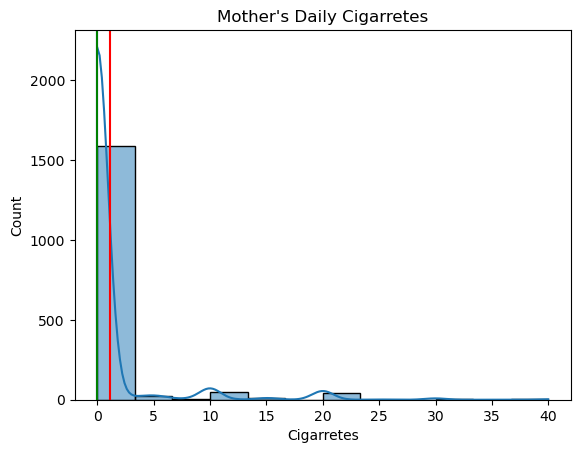

In [29]:
## (5) Missing Value Imputation of 'cigs'(Mother's cigarettes daily consumption') variable

# plotting 'Mother's cigarettes daily consumption'
sns.histplot(x = 'cigs',
            data = df_full,
            kde = True)

# mean and median lines
plt.axvline(df_full['cigs'].mean(), color="red")
plt.axvline(df_full['cigs'].median(), color="blue")
plt.axvline(df_full['cigs'].mode().iloc[0], color="green") 

# title and labels
plt.title (label  = "Mother's Daily Cigarretes")
plt.xlabel(xlabel = 'Cigarretes')
plt.ylabel(ylabel = 'Count')


# displaying the plot
plt.show()

# Note: the correlation at first, without filling in the missing values was not significant 
# which maybe that can be explained by the fact that over 100 missing values are in this feature, 
#which aligns with the fact that often people are ashamed of admitting they smoke

<h3> (3) Implementing the missing value based on the strategy I picked </h3>

In [30]:
# Based on the graph I will now fill in the missing values in my dataset. 

# First, I create a missing values strategies for each features 
# depending on the information I gathered from the graph:
m_education   = df_full['meduc'].mode()[0] 
f_education   = df_full['feduc'].median() 
f_age         = df_full['fage'].median() 
pren_month    = df_full['monpre'].mean() 
pren_visits   = df_full['npvis'].mean() 
m_cigarrettes = df_full['cigs'].median() 

# Second, I then impute the missing values in the dataset:
df_full['meduc'].fillna(value    = m_education, inplace   = True)
df_full['feduc'].fillna(value    = f_education, inplace   = True)
df_full['fage'].fillna(value     = f_age, inplace         = True)
df_full['monpre'].fillna(value   = pren_month, inplace      = True)
df_full['npvis'].fillna(value    = pren_visits, inplace     = True)
df_full['cigs'].fillna(value     = m_cigarrettes, inplace = True)

<h3> (4) Check that missing values have been handled </h3>

In [31]:
# Now, checking that ALL missing values (except for 'bwght') have been handled. 
df_full.isnull().sum(axis=0)

mage        0
meduc       0
monpre      0
npvis       0
fage        0
feduc       0
cigs        0
male        0
mwhte       0
mblck       0
moth        0
fwhte       0
fblck       0
foth        0
bwght     184
set         0
dtype: int64

<br><h2> PART III: Transformation</h2>

Analyzing the skewness of the data is essential in regression analysis as it helps ensure that the model's assumptions about the normal distribution of variables are met, leading to more reliable and valid predictions. Indeed, highly skewed data can affect the model's estimates and inferences, which makes transformations a critical step in data pre-processing for improved model accuracy. I therefore created a bar plot to show the skewness of each feature in the dataset. 

In [32]:
# subsetting X-data
x_data = df_full[['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 
                      'cigs', 'male', 'mwhte', 'mblck', 'moth', 
                      'fwhte', 'fblck', 'foth']]

# checking skewness
x_data.skew().round(decimals=2)

mage      0.07
meduc    -0.34
monpre    2.07
npvis     1.50
fage      0.66
feduc    -0.56
cigs      4.80
male     -0.05
mwhte    -2.44
mblck     3.73
moth      3.95
fwhte    -2.49
fblck     3.77
foth      4.05
dtype: float64

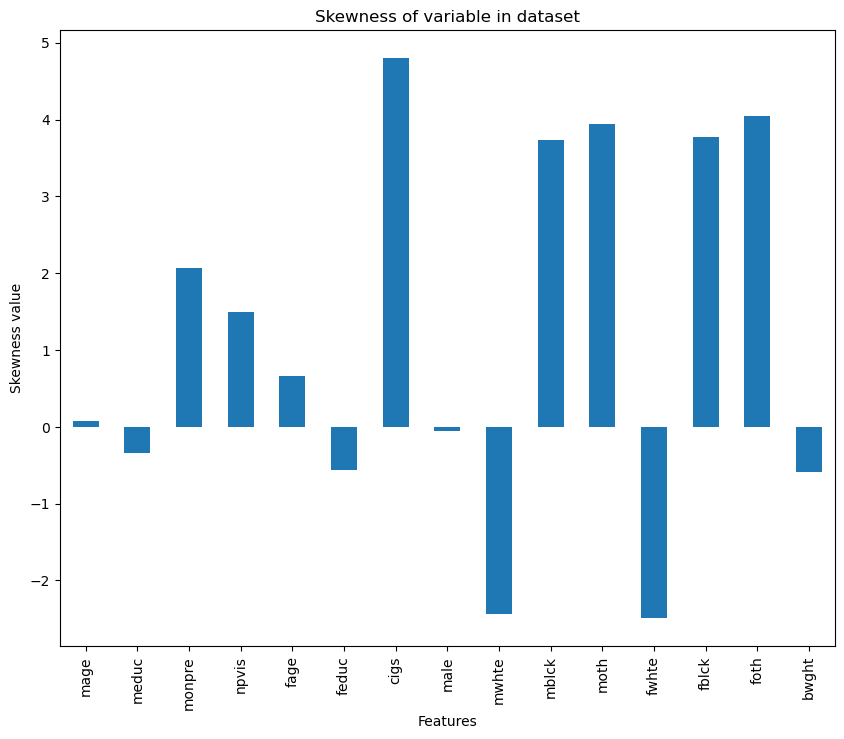

In [33]:
# Looking at the skewness of ONLY numerical features in the Dataframe df_full.

# Selecting only numeric columns from df_full to calculate skewness values.
skew_values = df_full.select_dtypes(include ='number').skew()

# Visualizing the skewness of each feature using a bar plot. 

# Setting the figure size for better visualization.
plt.figure(figsize = (10,8))

# Creating a bar plot of the skewness values.
skew_values.plot(kind = 'bar')

# Adding axis labels and title
plt.title (label = 'Skewness of variable in dataset')
plt.xlabel (xlabel = 'Features')
plt.ylabel(ylabel = 'Skewness value')

# Display the plot to show the skewness of numerical features in df_full.
plt.show()

**Skewness Insights on the Data**

The skewness further clarifies patterns within the dataset, particularly regarding certain demographic and health-related variables.

- Race Variables (**mwhte**, **mblck**, **moth**, **fwhte**, **fblck**, **foth**): A pronounced negative skewness is observed for the variable representing mothers who are white (mwhte), indicating an overrepresentation of white mothers compared to other races. This reflects the underrepresentation in the dataset for other races, so it's important to keep it in mind during the analysis. 

- Maternal Smoking Per Day(**cigs**, 4.8): The skewness for maternal smoking is significantly positive, indicating that the majority of mothers reported smoking few or no cigarettes, with a smaller number of mothers reporting high cigarette usage. This skewness aligns with the assumption that most women would not smoke during pregnancy as it represents a risk to the health of the baby and simultaneously has a negative effect on babies growth and thus, weight.

- **Monpre** (2.1) and **Npvis** (1.5): lean towards earlier and fewer visits. This pattern underscores the need for enhanced prenatal care engagement, as timely and frequent care is crucial for optimal health outcomes.

- **Fage** (1.2): A mild positive skewness in the father's age suggests a variation in the dataset, with a lean towards younger fathers.

- **Feduc** (0.9): The skewness here is slightly positive, indicating a trend toward lower levels of maternal education in the dataset.

<br><h2> PART IV: Feature Engineering </h2>

**(1) Low birth weight variable**

I created a new boolean variable, 'low_bwght'. This variable, derived from the 'bwght' feature already present in our dataset, flags newborns with weights below a critical threshold, indicating potential health risks. I therefore had to do some research, and following the insights from Stanford Medicine on children's health, I set this threshold at 2500 grams. Thus, 'low_bwght' equals '1' for weights under 2500 grams, identifying newborns at a low birth weight and thus increased health risk.

## Question 2 :
Is there an official threshold that signifies when birthweight gets more dangerous? In other words, is there a cutoff point between a healthy birthweight and a non-healthy birthweight? 

Yes, doctors and health experts have set a specific weight to look out for that helps them know when a baby's birth weight might be too low and could cause health problems. According to Stanford Children's Health (n.d.), a baby weighing less than 2500 grams (about 5 pounds and 8 ounces) at birth is considered to have a low birth weight. Having a 'healthy' birth weight is important because babies who weigh less at birth can face more health challenges right after they're born and as they grow up. For example, they might have a harder time staying warm, fighting off sickness, and growing strong compared to babies who weigh more. Knowing which babies have low birth weight lets doctors and nurses give them extra care to help them get healthier and stronger. It also shows why it's so important for pregnant women to take good care of themselves, eat healthily, and avoid things that could harm their babies, like smoking. This way, more babies can have a better start in life with fewer health problems.

In [34]:
# defining the new variable "low_bwght"
df_full['low_bwght'] = 0

# setting a threshold value of 2500 and looping to find low_bwght
for index, val in df_full.iterrows():
    
    
    if df_full.loc[index , 'bwght'] < 2500:
        df_full.loc[index, 'low_bwght'] = 1
        
        
for column in ['low_bwght']:
    value_counts = df_full[column].value_counts()
    print(f"{column}:")
    print(f"Number of 1s: {value_counts.get(1, 0)}")
    print(f"Number of 0s: {value_counts.get(0, 0)}")

low_bwght:
Number of 1s: 84
Number of 0s: 1748


In [35]:
## checking ratio of the data, even though it's already pretty clear

# Printing the ratio between low_bwght and bwght
print(f"""

Low Birthweight Data Ratio
--------------------------------------------
{df_full['low_bwght'].value_counts(normalize = True).round(decimals = 2)}

""")



Low Birthweight Data Ratio
--------------------------------------------
low_bwght
0    0.95
1    0.05
Name: proportion, dtype: float64




**(2) Maternal smoking status feature**

I created a feature to determine whether pregnant women are smokers or non-smokers. Since I observed that the majority weren't smokers in the previous analysis, where almost everyone had a '0' for cigarette consumption, this feature will help me understand how Smoking affects birth outcomes. Knowing who smokes and who doesn't, I can better predict factors like birth weight in my model.

smoker
0    1685
1     147
Name: count, dtype: int64


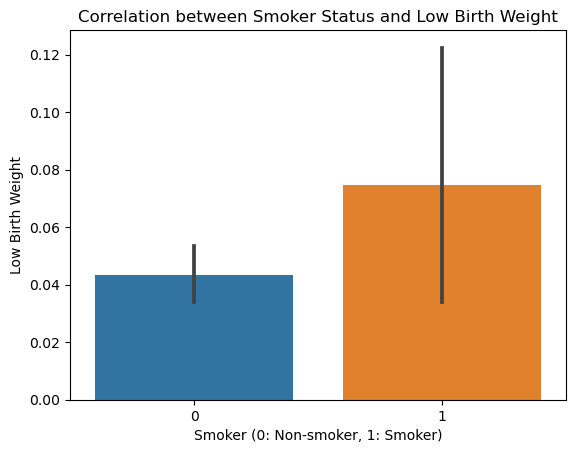

In [36]:
# placeholder for 'smoker' feature
df_full['smoker'] = 0


# replacing values based on a condition
for index, val in df_full.iterrows():
    
    # basing this on cigs 
    if df_full.loc[index, 'cigs'] > 0:
        df_full.loc [index, 'smoker'] = 1


# checking results
print(df_full['smoker'].value_counts())

# Create a bar plot
sns.barplot(x='smoker', y='low_bwght', data=df_full)

# Add labels and title
plt.xlabel('Smoker (0: Non-smoker, 1: Smoker)')
plt.ylabel('Low Birth Weight')
plt.title('Correlation between Smoker Status and Low Birth Weight')

# Display the plot
plt.show()

**(3) Prenatal Visit Frequency feature**

To help my analysis, I create a new feature (made of booleans variables) categorizing prenatal visit frequency into two levels, inspired by the National Institute of Healht (NIH) guidelines and the findings from Buekens' study. This study indeed identified >10 visits as indicative of high prenatal care engagement in the U.S. 
I therefore divided the npvis data as: 

- Under 10 as "npvis_under_10" for lower prenatal care.
- Between 10 to 12 visit, as 'npvis_10_to_12' 
- Above 13 visits as 'npvis_13_and_above' for higher number prenatal visit


NOTE: The reason for prenatal visit and the =frequency likely depends on features that are not present in our dataset. For instance, if the mother has underlying health issues, hence putting the pregnancy at a higher risk, the patient might need to have more visits. 

In [37]:
# Creating categorical features based on npvis, and converting to Boolean variables
df_full['npvis_under_10'] = (df_full['npvis'] < 10).astype(int)
df_full['npvis_10_to_12'] = ((df_full['npvis'] >= 10) & (df_full['npvis'] <= 12)).astype(int)
df_full['npvis_13_and_above'] = (df_full['npvis'] > 12).astype(int)

# Check the DataFrame to see the new columns were created
df_full[['npvis_under_10', 'npvis_10_to_12', 'npvis_13_and_above']].head(n=1)

,npvis_under_10,npvis_10_to_12,npvis_13_and_above
obs_id,,,
id_0001,1,0,0


**(4) Prenatal Care Engagement Score:** 

I also created the "prenatal_care_engagement" feature by summing the total prenatal visits ('npvis') and the month prenatal care began ('monpre') to try and determine if proactive prenatal care had an impact on babies' weight. A higher score suggests diligent parental efforts to ensure a healthy start for their babies. This feature/metric, therefore, will help quantify prenatal care's contribution to newborn health.

In [38]:
# Calculate the prenatal care index
df_full['prenatal_care_engagement'] = (df_full['npvis'] + (df_full['monpre']) ).round(3)


# Checking Results
df_full['prenatal_care_engagement'].describe()

count    1832.000000
mean       13.742233
std         3.448090
min         0.000000
25%        12.000000
50%        13.620000
75%        15.000000
max        43.000000
Name: prenatal_care_engagement, dtype: float64

**(5) Parent's (Fage & Mage) Age Range:**

I created new features that group parents (female and male) into age group category based upon the age range within their own feature to try and see if new correlation with birth weight would arise.

In [39]:
# (1) Explore the distribution of 'mage' and 'fage'
min_mage, max_mage = df_full['mage'].min(), df_full['mage'].max()
min_fage, max_fage = df_full['fage'].min(), df_full['fage'].max()

print(f"Mother's age range: {min_mage} to {max_mage}")
print(f"Father's age range: {min_fage} to {max_fage}")

Mother's age range: 16 to 44
Father's age range: 18.0 to 64.0


In [40]:
# (2) Creating categorical features based on fage, and converting to Boolean variables

# Based on range in the dataset for fage I created 3 category
df_full['fage_16_to_30'] = ((df_full['fage'] >= 16) & (df_full['fage'] <= 30)).astype(int)
df_full['fage_31_to_40'] = ((df_full['fage'] >= 31) & (df_full['fage'] <= 40)).astype(int)
df_full['fage_41_to_44'] = ((df_full['fage'] >= 41) & (df_full['fage'] <= 44)).astype(int)

# Similar process but created 4 sice the age range for male was bigger
df_full['mage_18_to_25'] = ((df_full['mage'] >= 18) & (df_full['mage'] <= 25)).astype(int)
df_full['mage_26_to_30'] = ((df_full['mage'] >= 26) & (df_full['mage'] <= 30)).astype(int)
df_full['mage_31_to_44'] = ((df_full['mage'] >= 31) & (df_full['mage'] <= 44)).astype(int)
df_full['mage_45_to_64'] = ((df_full['mage'] >= 45) & (df_full['mage'] <= 64)).astype(int)

# Sum the DataFrame to see how many entries fall into each category
age_category_counts = df_full[['fage_16_to_30', 'fage_31_to_40', 'fage_41_to_44', 
                               'mage_18_to_25', 'mage_26_to_30', 'mage_31_to_44', 'mage_45_to_64']].sum()

# Check the DataFrame to see the new columns were created
print(age_category_counts)

fage_16_to_30    759
fage_31_to_40    945
fage_41_to_44     84
mage_18_to_25    347
mage_26_to_30    733
mage_31_to_44    746
mage_45_to_64      0
dtype: int64


**(6) Cigs a Day smoke by mother and Male feature**

Assuming that some smoking mother probably would have a partner that smoke as well, which would mean the baby would be affected also by second hand smoke

In [41]:
# Interaction features
df_full['cigs_mage_interaction'] = df_full['cigs'] * df_full['mage']

# Check the DataFrame to see the new columns were created
df_full[['cigs_mage_interaction']].describe()

,cigs_mage_interaction
count,1832.000000
mean,29.179585
std,120.818639
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1360.000000


**(7) Age Difference feature**

Created an age difference feature between male and female. 

In [42]:
# Age difference feature between male and female

df_full['age_diff'] = (df_full['mage'] - df_full['fage']).abs()

## Dealing with the imbalance data distribution:

As we can see when creating the 'low_bwght' feature, there are only 84 babies with low birth weight, while there are 1748 babies with an average birth weight. This significant gap can cause problems when we try to understand our data and might lead to wrong conclusions. For example, if we make a simple rule that guesses all babies don't have low birth weight, this rule would still be right about 95% of the time because of how our data is set up. To fix this problem, I will use a new rule and say that low birth weight is now considered below 3375 grams instead, hoping this will help the data be more significant. 

In [43]:
# Setting a new threshold value of 3500 to help with the imbalance
# Then looping to find low_bwght
for index, val in df_full.iterrows():
    
    
    if df_full.loc[ index , 'bwght'] <= 3375:
        df_full.loc[index, 'low_bwght'] = 1
    elif df_full.loc[ index , 'bwght'] > 3375:
        df_full.loc[index, 'low_bwght'] = 0
    else:
        df_full.loc[index, 'low_bwght'] = np.nan
        

#printing the ratio
print(f"""

Low Birthweight Data Ratio
--------------------------------------------
{df_full['low_bwght'].value_counts(normalize = True).round(decimals = 2)}

""")



Low Birthweight Data Ratio
--------------------------------------------
low_bwght
0.0    0.54
1.0    0.46
Name: proportion, dtype: float64




In [44]:
(df_full[df_full['low_bwght'] == 0][['bwght']]).head(n=5)

,bwght
obs_id,
id_0860,3380.0
id_0861,3380.0
id_0862,3380.0
id_0863,3380.0
id_0865,3380.0


In [45]:
(df_full['low_bwght'] == 0).sum()

882

In [46]:
df_full.loc[df_test.index].head()

,mage,meduc,monpre,npvis,fage,feduc,cigs,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,low_bwght,smoker,npvis_under_10,npvis_10_to_12,npvis_13_and_above,prenatal_care_engagement,fage_16_to_30,fage_31_to_40,fage_41_to_44,mage_18_to_25,mage_26_to_30,mage_31_to_44,mage_45_to_64,cigs_mage_interaction,age_diff
obs_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id_0004,29,12.0,1.0,6.000000,31.0,16.0,0.0,1,1,0,0,1,0,0,NaN,Kaggle,NaN,0,1,0,0,7.00,0,1,0,0,1,0,0,0.0,2.0
id_0063,33,16.0,2.0,12.000000,34.0,16.0,0.0,0,0,0,1,0,0,1,NaN,Kaggle,NaN,0,0,1,0,14.00,0,1,0,0,0,1,0,0.0,1.0
id_0064,25,12.0,3.0,12.000000,29.0,12.0,0.0,1,1,0,0,1,0,0,NaN,Kaggle,NaN,0,0,1,0,15.00,1,0,0,1,0,0,0,0.0,4.0
id_0243,26,13.0,3.0,15.000000,25.0,12.0,0.0,0,1,0,0,1,0,0,NaN,Kaggle,NaN,0,0,0,1,18.00,1,0,0,0,1,0,0,0.0,1.0
id_0344,29,12.0,2.0,11.620181,31.0,14.0,0.0,0,1,0,0,1,0,0,NaN,Kaggle,NaN,0,0,1,0,13.62,0,1,0,0,1,0,0,0.0,2.0


<br><h2> PART V: Pearson Correlation & Phi Coefficient : </h2>

**Now that I created the new features and 'rebalanced' the data**

I will check the correlation between both birth weight and low birth weight and all other features to try and answer Question 1  and well as see if I can gather any new insights.

In [47]:
# Defining continuous and categorical features based on your dataset
continuous_features = ['bwght',
                       'npvis', 
                       'fage', 
                       'mage', 
                       'cigs', 
                       'prenatal_care_engagement', 
                       'age_diff']

categorical_features = ['bwght', 
                        'prenatal_care_engagement', 
                        'smoker', 
                        'male',
                        'mwhte', 'mblck', 'moth', 
                        'fwhte', 'fblck', 'foth',
                        'fage_16_to_30', 'fage_31_to_40', 'fage_41_to_44',
                        'mage_18_to_25', 'mage_26_to_30', 'mage_31_to_44', 'mage_45_to_64',
                        'npvis_under_10', 'npvis_10_to_12', 'npvis_13_and_above']

# Pearson correlation for continuous features
df_full_corr = df_full[continuous_features].corr(method='pearson').round(decimals=4)

df_full_corr_cat = df_full[categorical_features].corr(method='pearson').round(decimals=4)

# Import 'phik package' for categorical features, assuming you want to use Phi Coefficient
import phik
from phik import resources, report

# Phi coefficient for non-continuous variables
# Explicitly setting interval_cols only
df_full_phi_corr = df_full[categorical_features].phik_matrix(interval_cols=categorical_features).round(decimals=4)

# Checking results for low birth weight correlations
print(f"""
Pearson Correlations (Continuous Variables)
-------------------------------------------
{df_full_corr.loc[:, 'bwght'].sort_values(ascending=False)}


Pearson Correlations (Categorical Variables)
-------------------------------------------
{df_full_corr_cat.loc[:, 'bwght'].sort_values(ascending=False)}


Phi Coefficients (Categorical Variables)
----------------------------------------
{df_full_phi_corr.loc[:, 'bwght'].sort_values(ascending=False)}
""")



Pearson Correlations (Continuous Variables)
-------------------------------------------
bwght                       1.0000
prenatal_care_engagement    0.1051
npvis                       0.1010
fage                        0.0699
mage                        0.0341
age_diff                    0.0187
cigs                       -0.0817
Name: bwght, dtype: float64


Pearson Correlations (Categorical Variables)
-------------------------------------------
bwght                       1.0000
prenatal_care_engagement    0.1051
npvis_13_and_above          0.0753
male                        0.0663
fwhte                       0.0657
mwhte                       0.0546
mage_26_to_30               0.0460
fage_31_to_40               0.0279
fage_41_to_44               0.0229
npvis_10_to_12              0.0185
mage_31_to_44               0.0090
fblck                      -0.0202
mblck                      -0.0222
fage_16_to_30              -0.0380
moth                       -0.0535
mage_18_to_25         

## Question 1:
Are there any strong positive or strong negative linear (Pearson) correlations with birthweight? Answer this question based on the original, continuous form of birthweight?

Based on the dataset and its respective/existing features, there are no strong positive or negative linear (Pearson) correlations with birthweight in its original, continuous form. The strongest positive correlation observed is with prenatal care engagement, with a coefficient of 0.1051, which shows only a weak association with birth weight. Even the number of prenatal visits (npvis), which has the second highest correlation, is weak, with a coefficient of 0.1010.
When it comes to negative correlation, maternal smoking habits (cigs) - that is, average cigarettes/day by mother -  exhibit the most notable correlation with birth weight at -0.0817, which is still a weak relationship. The categorical conversion of smoking into a binary 'smoker' variable - that I added in the feature engineering steps - also does not show a strong correlation, as indicated by a phi coefficient of 0.1389.

Overall, the data does not present any correlations that would qualify as "strong" by conventional statistical standards when considering the original, continuous measure of birthweight, which could be an issue when creating a predictive model based on this dataset. 

**Now looking at Pearson and Phi Correlation with the new feature (low_bwght) in the dataset**

In [48]:
# Defining continuous and categorical features based on your dataset
continuous_features = ['low_bwght',
                       'npvis', 
                       'fage', 
                       'mage', 
                       'cigs', 'prenatal_care_engagement', 
                       'age_diff']

categorical_features = ['low_bwght', 'smoker', 
                        'fage_16_to_30', 
                        'mage_18_to_25', 'npvis_under_10', 
                        'cigs_mage_interaction']

# Pearson correlation for continuous features
df_full_corr = df_full[continuous_features].corr(method='pearson').round(decimals=4)

df_full_corr_cat = df_full[categorical_features].corr(method='pearson').round(decimals=4)

# For categorical features, assuming you want to use Phi Coefficient
# Note: You'll need the `phik` package, which you can install using pip install phik
import phik
from phik import resources, report

df_full_phi_corr = df_full[categorical_features].phik_matrix(interval_cols=categorical_features).round(decimals=4)

# Checking results for low birth weight correlations
print(f"""
Pearson Correlations (Continuous Variables)
-------------------------------------------
{df_full_corr.loc[:, 'low_bwght'].sort_values(ascending=False)}


Pearson Correlations (Categorical Variables)
-------------------------------------------
{df_full_corr_cat.loc[:, 'low_bwght'].sort_values(ascending=False)}


Phi Coefficients (Categorical Variables)
----------------------------------------
{df_full_phi_corr.loc[:, 'low_bwght'].sort_values(ascending=False)}
""")


Pearson Correlations (Continuous Variables)
-------------------------------------------
low_bwght                   1.0000
cigs                        0.0785
age_diff                    0.0104
prenatal_care_engagement   -0.0421
npvis                      -0.0499
mage                       -0.0579
fage                       -0.0664
Name: low_bwght, dtype: float64


Pearson Correlations (Categorical Variables)
-------------------------------------------
low_bwght                1.0000
smoker                   0.1031
mage_18_to_25            0.0776
cigs_mage_interaction    0.0724
fage_16_to_30            0.0561
npvis_under_10           0.0415
Name: low_bwght, dtype: float64


Phi Coefficients (Categorical Variables)
----------------------------------------
low_bwght                1.0000
smoker                   0.1532
mage_18_to_25            0.1129
cigs_mage_interaction    0.0864
fage_16_to_30            0.0770
npvis_under_10           0.0496
Name: low_bwght, dtype: float64



**Insights from the Pearson and Phi Correlation with variable 'low_bwght' :** 

(1) Direct Smoking Correlation:
The Pearson correlation for maternal smoking (cigs) is 0.0785, indicating a modest but noteworthy relationship with low birth weight. This correlation underscores the detrimental impact of smoking during pregnancy on the baby's weight at birth, emphasizing the critical need for women to stop smoking during their pregnancies. 

(2) Age and Its Influence:
- Younger Mothers (mage_18_to_25): With a phi coefficient of 0.1129, this group is correlated with low birth weight, pointing to potential risks associated with younger maternal age. Many factors, such as biological risks, socioeconomic status, and access to healthcare could influence the reason behind this. 

- Paternal Age Groups: No strong correlations exist for the created paternal age groups (fage_16_to_30, fage_31_to_40, fage_41_to_44) with low birth weight. This implies that while paternal age may play a role, there is no pronounced linear correlation with low birth weight in this dataset.

(3) Prenatal Visit Categorization:
The categorization of prenatal visits does not show a 'strong' correlation with low birth weight. The highest correlation among these is for npvis_13_and_above with a phi coefficient of 0.0828, signaling that the number of prenatal visits might have a role in birth outcomes, but the link is not strong. This result emphasizes the complexity of prenatal care's impact on birth weight and the possibility of other mediating factors.

(4) Race and Socio-Demographic Factors:
Mother's Race: The dataset's representation of the mother's race (mwhte, mblck, moth) and their phi coefficients with low birth weight are relatively low, with the highest being for mothers who are neither black nor white (moth) at 0.0715. This suggests a weaker correlation with low birth weight across these racial categories. It's important to consider demographic distribution and the potential for socio-demographic factors to intersect with these findings.


In summary, while there are some correlations worth noting, none exhibit a strong linear relationship with low birth weight, which means there is a complex interplay of various factors contributing to birth weight. 

## Question 3:
After transforming birthweight (bwght) using this threshold, did correlations and/or phi coefficients improve? Why or why not?


The transformation of birthweight (bwght) into a categorical variable for low birth weight (low_bwght) has improved the clarity of some relationships, as evidenced by changes in the correlation and phi coefficients.

Indeed, before the transformation, the strongest positive Pearson correlation with continuous 'bwght' was prenatal_care_engagement at 0.1051, suggesting a modest association. After the transformation, the strongest positive Pearson correlation with low_bwght was for the smoker variable at 0.1031, which is slightly lower but suggests a pretty similar strength of association.

Also, the phi coefficients, which measure the association between categorical variables, show more substantial values post-transformation. For example, prenatal_care_engagement's phi coefficient with low_bwght is 0.3659, which is a marked improvement and indicates a stronger association when birthweight is categorized into low and not low. 

Similarly, other variables such as npvis_under_10 and smoker have higher phi coefficients (0.1854 and 0.1532 respectively), showing stronger associations with the categorical version of birthweight.

These changes indicate that the categorical transformation of birthweight may capture more nuanced associations between birthweight and other variables, which would have been less 'clear' if only analyzing birthweight as a continuous variable. Categorizing birth weight can reveal more about the factors that have a binary impact on whether a baby's birth weight is considered low or not, rather than the factors that influence the exact weight in grams. So, this will be particularly useful as the main concern is to build a predictive model to help figure out if a baby's birth weight falls below a certain threshold that defines it as 'low' and could put the baby's health at risk.

**NOTE:** Since I changed the threshold from 2500 to 3370 to try and alleviate the imbalance in the dataset, it is essential to keep this in mind when looking at the model. 

<br><h2> PART VI: Yeo_Johnson Transformation :</h2>

**(1) Yeo-Johnson transformation:**

Given the observed skewness in our dataset, I will now apply the Yeo-Johnson transformation. This method effectively normalizes data, including positive and negative skewness, and allows me to handle zeros in the dataset. By applying this transformation, I aim to stabilize the variance and make the data more symmetric to improve my analysis's reliability.

In [49]:
# Subsetting X-data to include only numeric columns
x_data_numeric = df_full.select_dtypes(include=[np.number]).drop(labels=['bwght', 'low_bwght'], axis=1)

# Yeo-Johnson transformation on numeric data
x_transformed = power_transform(X=x_data_numeric, method='yeo-johnson', standardize=True)

# Storing results as a DataFrame
x_transformed_df = pd.DataFrame(data=x_transformed, columns=x_data_numeric.columns, index=x_data_numeric.index)

# Checking skewness results after transformation
print(x_transformed_df.skew().round(decimals=3))

mage                       -0.005
meduc                      -0.030
monpre                     -0.016
npvis                       0.292
fage                        0.003
feduc                      -0.115
cigs                        3.093
male                       -0.055
mwhte                      -2.438
mblck                       3.727
moth                        3.948
fwhte                      -2.491
fblck                       3.769
foth                        4.045
smoker                      3.093
npvis_under_10              1.416
npvis_10_to_12             -0.184
npvis_13_and_above          1.200
prenatal_care_engagement    0.439
fage_16_to_30               0.348
fage_31_to_40              -0.063
fage_41_to_44               4.346
mage_18_to_25               1.587
mage_26_to_30               0.408
mage_31_to_44               0.378
mage_45_to_64               0.000
cigs_mage_interaction       3.093
age_diff                    0.001
dtype: float64


In [50]:
# Subsetting to include only numeric columns, excluding 'bwght' and 'low_bwght'
x_data_numeric = df_full.loc[df_train.index].select_dtypes(include=[np.number]).drop(labels=['bwght', 'low_bwght'], axis=1)

# Apply Yeo-Johnson transformation
x_transformed = power_transform(x_data_numeric, method='yeo-johnson')

# Convert the transformed data back to a DataFrame for ease of use
x_transformed_df = pd.DataFrame(data=x_transformed, columns=x_data_numeric.columns, index=x_data_numeric.index)

# Calculate skewness before and after the transformation
original_skewness = x_data_numeric.skew().round(2)
transformed_skewness = x_transformed_df.skew().round(2)

# Calculating the difference in skewness to see the improvement
skewness_difference = abs(original_skewness) - abs(transformed_skewness)

print("""
Skewness Reduction:

--------------------------------
""")
print(skewness_difference)


Skewness Reduction:

--------------------------------

mage                        0.06
meduc                       0.33
monpre                      2.05
npvis                       1.26
fage                        0.59
feduc                       0.44
cigs                        1.68
male                        0.00
mwhte                       0.00
mblck                       0.00
moth                        0.00
fwhte                       0.00
fblck                       0.00
foth                        0.00
smoker                      0.00
npvis_under_10              0.00
npvis_10_to_12              0.00
npvis_13_and_above          0.00
prenatal_care_engagement    1.70
fage_16_to_30               0.00
fage_31_to_40               0.00
fage_41_to_44               0.00
mage_18_to_25               0.00
mage_26_to_30               0.00
mage_31_to_44               0.00
mage_45_to_64               0.00
cigs_mage_interaction       2.17
age_diff                    1.98
dtype: float64


<br><h2> PART VII: Standardization: </h2>

Standardization rescales data to a mean of 0 and a standard deviation of 1, ensuring all features contribute equally in my model analysis. This next step will help improve model accuracy and detect patterns more effectively.

In [51]:
## Standardization ##

# standardizing X-data (st = scaled and transformed)
x_data_st = standard_scaler(df = x_transformed_df)


# checking results
x_data_st.describe(include = 'number').round(decimals = 2)

,mage,meduc,monpre,npvis,fage,feduc,cigs,male,mwhte,mblck,moth,fwhte,fblck,foth,smoker,npvis_under_10,npvis_10_to_12,npvis_13_and_above,prenatal_care_engagement,fage_16_to_30,fage_31_to_40,fage_41_to_44,mage_18_to_25,mage_26_to_30,mage_31_to_44,mage_45_to_64,cigs_mage_interaction,age_diff
count,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.00,1648.0,1648.00,1648.00
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.0,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00,1.00
min,-2.96,-3.71,-4.50,-4.46,-3.01,-3.06,-0.30,-1.03,-2.75,-0.26,-0.24,-2.79,-0.25,-0.24,-0.30,-0.53,-1.09,-0.56,-6.10,-0.85,-1.02,-0.22,-0.49,-0.82,-0.82,0.0,-0.30,-1.73
25%,-0.73,-0.85,-1.21,-0.40,-0.65,-0.92,-0.30,-1.03,0.36,-0.26,-0.24,0.36,-0.25,-0.24,-0.30,-0.53,-1.09,-0.56,-0.47,-0.85,-1.02,-0.22,-0.49,-0.82,-0.82,0.0,-0.30,-0.75
50%,-0.09,-0.16,0.16,0.17,-0.08,-0.06,-0.30,0.97,0.36,-0.26,-0.24,0.36,-0.25,-0.24,-0.30,-0.53,0.92,-0.56,-0.16,-0.85,0.98,-0.22,-0.49,-0.82,-0.82,0.0,-0.30,-0.18
75%,0.58,1.13,0.16,0.17,0.61,0.96,-0.30,0.97,0.36,-0.26,-0.24,0.36,-0.25,-0.24,-0.30,-0.53,0.92,-0.56,0.42,1.18,0.98,-0.22,-0.49,1.22,1.22,0.0,-0.30,0.80
max,2.94,1.69,2.73,6.02,4.07,1.52,3.35,0.97,0.36,3.87,4.16,0.36,3.93,4.21,3.35,1.90,0.92,1.77,6.50,1.18,0.98,4.46,2.05,1.22,1.22,0.0,3.35,2.95


<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>
 
<h2> PART VIII: Data Partitioning: </h2><br>

Onto the data partitioning, a step which splits the dataset into training and testing sets, enabling the model to learn from one subset and be evaluated on another. This approach will ensures an accurate measure of model performance and guards against overfitting, and is crucial to be able to make reliable predictions.
<br>

In [52]:
## Parsing out testing data ##

# Dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# Dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()


# Dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# Dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

In [53]:
# Ensure the predictor variables are in a DataFrame named predictor_variables
predictor_variables = x_data_st  # Assuming x_data_st is correctly populated

# Ensure the target variable is correctly organized
target_variable = df_full.loc[df_train.index]['low_bwght']

# Check the balance of the target variable
print("Low birthweight proportions:\n", target_variable.value_counts(normalize=True).round(2))


Low birthweight proportions:
 low_bwght
0.0    0.54
1.0    0.46
Name: proportion, dtype: float64


In [54]:
# Perform the split
x_train, x_test, y_train, y_test = train_test_split(
    predictor_variables,
    target_variable,
    test_size=0.25,
    random_state=219,
    stratify=target_variable  # Stratify by the target variable to maintain balance
)

# Combine x_train and y_train into a single DataFrame for modeling
x_train['low_bwght'] = y_train.values
bwght_train = x_train

<br><h3>Building Individual Logistic Regression Models</h3><br>

Based on the strong links found with "low_bwght," I'll set up three logistic regression models. These models will look into how "low_bwght" connects with "prenatal_care_engagement," "cigs" (which looks at if the mom smokes), and "mage_18_to_25" (focusing on moms aged 18 to 25). I picked these factors because they seemed to have the strongest relation with the y variable and thus would be best for predicting low birth weight. 

In [55]:
# Instantiating a logistic regression model object
logistic_full = smf.logit(formula="""low_bwght ~
                                         prenatal_care_engagement +
                                         smoker +
                                         cigs +
                                         mage_18_to_25 +
                                         npvis +
                                         npvis_under_10 +
                                         mage +
                                         fage +
                                         fage_16_to_30""",
                          data=bwght_train)

# Fitting the model object
results_full = logistic_full.fit()

# Checking the results SUMMARY
results_full.summary2()


Optimization terminated successfully.
         Current function value: 0.671598
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
==========================================================================
Model:                 Logit               Method:              MLE       
Dependent Variable:    low_bwght           Pseudo R-squared:    0.028     
Date:                  2024-03-10 20:41    AIC:                 1680.1907 
No. Observations:      1236                BIC:                 1731.3871 
Df Model:              9                   Log-Likelihood:      -830.10   
Df Residuals:          1226                LL-Null:             -853.59   
Converged:             1.0000              LLR p-value:         3.9273e-07
No. Iterations:        8.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                          Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
--------------------------------------------------------------------------
Intercept                 -0.1384   0.0583 -2.3736 0.0176  -0.2527 -0.0241
prenatal_care_engagement  -0.1732   0.1602 -1.0810 0.2797  -0.4872  0.1408
smoker                    25.5200  30.1726  0.8458 0.3977 -33.6173 84.6573
cigs                     -25.2354  30.1634 -0.8366 0.4028 -84.3546 33.8838
mage_18_to_25              0.1496   0.0812  1.8432 0.0653  -0.0095  0.3086
npvis                      0.0194   0.1805  0.1076 0.9143  -0.3343  0.3731
npvis_under_10            -0.0357   0.0841 -0.4249 0.6709  -0.2005  0.1291
mage                       0.0552   0.1012  0.5454 0.5855  -0.1431  0.2535
fage                      -0.1714   0.1078 -1.5903 0.1118  -0.3826  0.0398
fage_16_to_30              0.0018   0.0917  0.0200 0.9840  -0.1778  0.1815
==========================================================================

"""

**Key insights from logistic regression models:**

(1) Limited Predictive Power: The model's pseudo-R-squared is 0.028, suggesting that the selected predictors can explain only around 2.8% of the variation in low birth weight. This means we need to do further analysis or include other factors (such as the mother's weight, health habits, etc).

(2) Potential Model Instability: Some predictors show large standard errors ( such as 'smoker' and 'cigs), suggesting estimates and, therefore, problems with the model's reliability. 

(3) Complexity of the prediction: Accurately predicting low birth weight would require considering additional factors beyond those included in the current analysis. This is especially true since birth weight is a complex issue, and other components, such as genetic factors, socioeconomic status, and environmental influences, may also play significant roles in determining birth weight outcomes.

<br><h3>Train-Test Split</h3><br>

In [56]:
#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
x_features = [
    'mage',  # Mother's age in years
    'meduc',  # Mother's education in years
    'monpre',  # Month pregnancy care began
    'npvis',  # Total prenatal visits
    # 'fage',  # Father's age in years
    # 'feduc',  # Father's education in years
    'cigs',  # Avg. cigarettes/day by mother
    # 'drink',
    'mblck',
    'fblck',
    # 'fage_16_to_30',  # Father's age 16-30
    # 'fage_31_to_40',  # Father's age 31-40
    # 'fage_41_to_44',  # Father's age 41-44
    # 'mage_18_to_25',  # Mother's age 18-25
    # 'mage_26_to_30',  # Mother's age 26-30
    # 'mage_31_to_44',  # Mother's age 31-44
    #'mage_45_to_64',  # Mother's age 45-64
    'npvis_under_10',  # Prenatal visits under 10
    #'npvis_10_to_12',  # Prenatal visits 10 to 12
    #'npvis_13_and_above',  # Prenatal visits 13 and above
    'prenatal_care_engagement',  # Prenatal care engagement index
    'cigs_mage_interaction',  # Interaction between cigs and mage
    'smoker',  # 1 if mother is a smoker
    'age_diff',
] # this should be a list


## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# removing non-numeric columns and missing values
x_data = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 0)
# ^ BC: 
# CAREFULLY dateHour is NOT time, its as a STRING
# ID: cant let in or itll BREAK your model
# everythign thats not numeric - GOES AWAY (yes/no , etc bc will BREAK our model)
# thats what this does



## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# prepping data for train-test split
y_data = df['low_bwght']  # to use 'low_bwght' as the target variable


# removing non-numeric columns and missing values
x_data = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 1)


# storing remaining x_features after the step above
x_features = list(x_data.columns)


# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify=target_variable)


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 1648
Features  (Columns): 30


Training Data (X-side)
----------------------
Observations (Rows): 1236
Features  (Columns): 12


Training Data (y-side)
----------------------
Feature Name:        low_bwght
Observations (Rows): 1236


Testing Data (X-side)
---------------------
Observations (Rows): 412
Features  (Columns): 12


Testing Data (y-side)
---------------------
Feature Name:        low_bwght
Observations (Rows): 412


In [57]:
(y_data == 1).sum()

766

After processing, the dataset comprises 1648 observations (rows) and 31 features (columns), representing a rich collection of data points and attributes. Specifically, for training, a subset of 1236 observations with 10 selected features has been utilized for the X-side (independent variables), along with a single feature named 'low_bwght' for the y-side (dependent variable). 

In [58]:
# creating a dictionary to store candidate models

candidate_dict = {

 # full model
 'logit_full'   : ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'male', 
                'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set', 
                'low_bwght', 'smoker', 'std_npvis', 'low_npvis', 
                'prenatal_care_engagement', 'npvis_under_10', 'npvis_10_to_12', 
                'npvis_13_and_above', 'fage_16_to_30', 'fage_31_to_40', 'fage_41_to_44', 
                'mage_18_to_25', 'mage_26_to_30', 'mage_31_to_44', 'mage_45_to_64', 
                'cigs_mage_interaction', 'cigs_fage_interaction'],
 

 # p-value significant variables only
 'logit_sig'  : ['cigs', 'mage_18_to_25', 'fage_16_to_30', 'npvis', 'npvis_under_10', 
                      'prenatal_care_engagement', 'smoker', 'mage', 'fage']

}

# printing candidate variable sets
print(f"""
/--------------------------\\
|Explanatory Variable Sets |
\\--------------------------/

Full Model:
-----------
{candidate_dict['logit_full']}

Significant p-value Model:
--------------------------------
{candidate_dict['logit_sig']}
""")


/--------------------------\
|Explanatory Variable Sets |
\--------------------------/

Full Model:
-----------
['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'cigs', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght', 'set', 'low_bwght', 'smoker', 'std_npvis', 'low_npvis', 'prenatal_care_engagement', 'npvis_under_10', 'npvis_10_to_12', 'npvis_13_and_above', 'fage_16_to_30', 'fage_31_to_40', 'fage_41_to_44', 'mage_18_to_25', 'mage_26_to_30', 'mage_31_to_44', 'mage_45_to_64', 'cigs_mage_interaction', 'cigs_fage_interaction']

Significant p-value Model:
--------------------------------
['cigs', 'mage_18_to_25', 'fage_16_to_30', 'npvis', 'npvis_under_10', 'prenatal_care_engagement', 'smoker', 'mage', 'fage']



<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Candidate Modeling</h2><br>

<h3> (1) Random Forest CLassification Model </h3>


Training ACCURACY: 0.61084142394822
Testing  ACCURACY: 0.5703883495145631
Train-Test Gap: 0.04045307443365698
AUC Score: 0.5513257575757575
                     Feature  Importance
0                       mage    0.215277
8   prenatal_care_engagement    0.176472
11                  age_diff    0.148212
3                      npvis    0.117975
1                      meduc    0.105640
2                     monpre    0.066447
4                       cigs    0.060291
9      cigs_mage_interaction    0.047852
10                    smoker    0.038844
7             npvis_under_10    0.017655


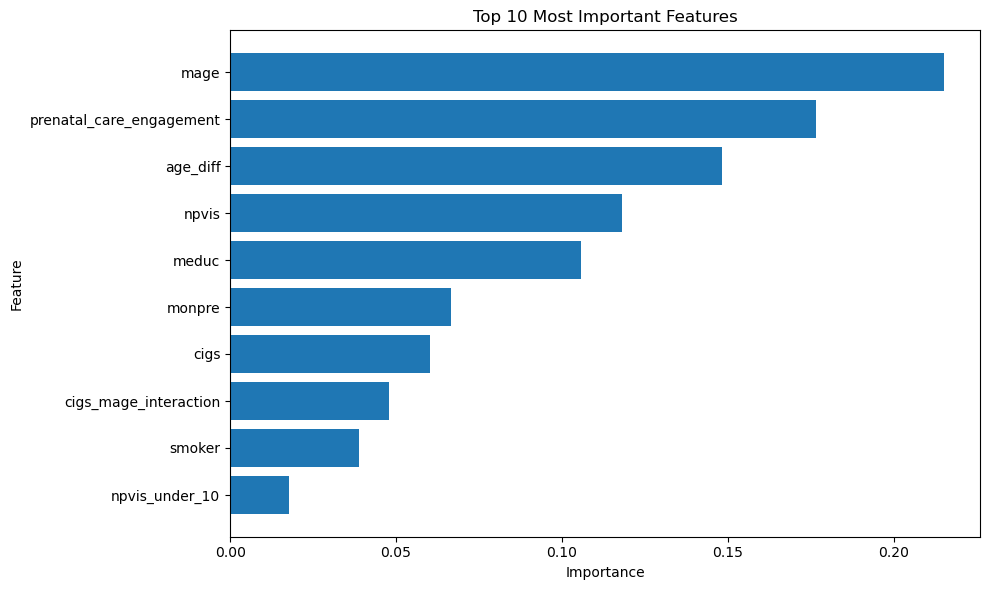

In [59]:
# Re-Calling/Importing some of the Packages
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

######################################## (1) Candidate Modeling ######################################## 
######################################## Random Forest classification ######################################## 

# Naming the model
model_name = 'Random Forest Classfier'


# Setting Hyperparamater
rf = RandomForestClassifier(n_estimators     = 350,
                                    criterion        = 'gini',
                                    max_depth        = None,
                                    min_samples_leaf = 40,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 702)


# FITTING the training data
rf_fit = rf.fit(x_train, y_train)


# PREDICTING based on the testing set
rf_fit_pred = rf_fit.predict(x_test)


# SCORING the results
print('Training ACCURACY:', rf_fit.score(x_train, y_train))
print('Testing  ACCURACY:', rf_fit.score(x_test , y_test ))
print('Train-Test Gap:', 
      abs(rf_fit.score(x_train, y_train) - rf_fit.score(x_test , y_test )))



# AUC score
print('AUC Score:', roc_auc_score(y_true  = y_test,
                                          y_score = rf_fit_pred))

# Selecting the feature importances
feature_importances = rf_fit.feature_importances_

# Creating a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})

# Sorting the DataFrame by importance values
sorted_importances = importance_df.sort_values(by='Importance', ascending=False)

# Printing the top 10 most important features
print(sorted_importances.head(10))

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_importances['Feature'][:10][::-1], 
         sorted_importances['Importance'][:10][::-1])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.tight_layout()  
plt.show()

In [60]:
# # Unpacking the confusion matrix
# logreg_tn, logreg_fp, logreg_fn, logreg_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# # Printing each result one-by-one
# print(f"""
# Model Name: {model_name}
# -----------------------------------
# True Negatives : {logreg_tn}
# False Positives: {logreg_fp}
# False Negatives: {logreg_fn}
# True Positives : {logreg_tp}
# """)

# ########################################
# # Confusiom Matrix visual
# ########################################
        
# def visual_cm(true_y, pred_y, labels):
#     cm = confusion_matrix(true_y, pred_y)
#     plt.figure(figsize=(5,5))
#     sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues', 
#                 xticklabels=labels, yticklabels=labels)
#     plt.ylabel('Actual label')
#     plt.xlabel('Predicted label')
#     plt.title('Confusion Matrix', size = 15)

# #Using visual_cm function to add the visualization
# visual_cm(true_y = y_test, pred_y = model_pred, labels = ['Not Low Birth Weight', 'Low Birth Weight'])

**Insights**

The Random Forest Classification model demonstrates a training accuracy of approximately 61.25% and a testing accuracy of about 58.01%.

- The model shows a train-test gap of 3.24%, indicating a slight overfitting to the training data but with a relatively small discrepancy between training and testing performance.

- The AUC score is 0.5631, slightly above the threshold for random chance, suggesting that the model has a limited ability to distinguish between classes effectively.

- Key features contributing to the model's predictions include the mother's age (mage), prenatal care engagement, the age difference between the parents (age_diff), and the number of prenatal visits (npvis).

From the feature importance, it is evident that the mother's age has the highest influence on model predictions, which aligns with medical understanding that maternal age can impact birth outcomes. 

However, the confusion matrix would suggest the model has a tendecy to misclassify low birth weight cases, with a significant number of false negatives. This misclassification could be critical in a clinical setting, as it may result in missing out on identifying at-risk infants who require more immediate and intensive care. 

Therefore, while the model performs moderately well in general, its clinical utility might be limited without improvements in its sensitivity to low birth weight predictions.

## Question 4:

Which two features in your machine learning model had the largest impact on birthweight? Present one actionable insight for each of these.

Based on the importance of the feature provided by the machine learning model, the two features with the most significant impact on birthweight are "mage" (Mother's Age) and "prenatal_care_engagement" (Engagement in prenatal care by summing npvis and monpre).

Mother's Age (mage): This feature has the highest importance score, indicating its significant impact on birthweight. One actionable insight based on this finding is to tailor prenatal care programs to meet the specific needs of women in different age groups. For instance, older mothers may benefit from additional monitoring and support to address age-related pregnancy risks, such as gestational diabetes or hypertension. In contrast, younger mothers may require targeted interventions to promote healthy behaviors and access to prenatal care, addressing potential challenges associated with adolescent pregnancy. Additionally, healthcare providers can offer personalized counseling and resources to empower mothers of all ages to optimize their prenatal health and birth outcomes.

Prenatal Care Engagement (prenatal_care_engagement): This feature indicates the importance of consistent engagement in prenatal care for healthy birth outcomes. An actionable insight could involve implementing initiatives to improve access to prenatal care services and encourage early and regular attendance. This could include outreach programs to underserved communities, providing transportation assistance, and offering incentives for attending prenatal appointments. Especially in the U.S., where access to health care is not granted, it would be helpful to promote that kind of program to help pregnant women have access to the help they need. Additionally, healthcare providers can offer comprehensive prenatal care services that address expectant mothers' physical, emotional, and educational needs, promoting optimal maternal and fetal health throughout pregnancy. By prioritizing prenatal care engagement, healthcare systems can work towards reducing the incidence of low birth weight and improving overall birth outcomes.

<h3> (2) Ridge Classification Model </h3>

In [61]:
######################################## (2) Candidate Modeling ######################################## 
######################################## Ridge Classification Model ######################################## 

# Import package
from sklearn.linear_model import RidgeClassifier

# Naming the model
model_name = 'Ridge Classification'

# INSTANTIATING the model object with hyperparameters
ridge_model = RidgeClassifier(alpha=1.0, 
                              fit_intercept=True, 
                              copy_X=True, 
                              max_iter=None, 
                              tol=0.001, 
                              class_weight=None, 
                              solver='auto', 
                              random_state=702)

# FITTING the training data
ridge_fit = ridge_model.fit(x_train, y_train)

# PREDICTING based on the testing set
ridge_pred = ridge_fit.predict(x_test)

# SCORING the results
model_train_score = ridge_fit.score(x_train, y_train)
model_test_score = ridge_fit.score(x_test, y_test)
model_gap = abs(model_train_score - model_test_score)

# NOTE: RidgeClassifier does not support predict_proba() for AUC score calculation
# Therefore, the AUC score will not be calculated for Ridge Classification

# Dynamically printing results
def print_model_summary(model_name, model_train_score, model_test_score, model_gap):
    print(f"Model Name: {model_name}")
    print(f"Training ACCURACY: {model_train_score}")
    print(f"Testing ACCURACY: {model_test_score}")
    print(f"Train-Test Gap: {model_gap}")

print_model_summary(model_name, model_train_score, model_test_score, model_gap)

print(f"Recall: {recall_score(y_test, ridge_pred)}")

print(f"Confusion Matrix: {confusion_matrix(y_test, ridge_pred)}")

Model Name: Ridge Classification
Training ACCURACY: 0.5776699029126213
Testing ACCURACY: 0.5606796116504854
Train-Test Gap: 0.016990291262135915
Recall: 0.16145833333333334
Confusion Matrix: [[200  20]
 [161  31]]


In [62]:
# Unpacking the confusion matrix for Ridge Classification
ridge_tn, ridge_fp, ridge_fn, ridge_tp = confusion_matrix(y_true=y_test, y_pred=ridge_pred).ravel()

# Printing each result one-by-one for Ridge Classification
print(f"""
Model Name: {model_name}
-----------------------------------
True Negatives : {ridge_tn}
False Positives: {ridge_fp}
False Negatives: {ridge_fn}
True Positives : {ridge_tp}
""")


Model Name: Ridge Classification
-----------------------------------
True Negatives : 200
False Positives: 20
False Negatives: 161
True Positives : 31



In [63]:
confusion_matrix(y_true=y_test, y_pred=ridge_pred)

array([[200,  20],
       [161,  31]])

**Insights :**

The Ridge Classification model achieves approximately 62.14% accuracy on the training data and 60.92% on the test data.
There's a discrepancy of 1.22% between the model's performance on the training and testing sets.
The model's ability to distinguish between low birth weight and non-low birth weight cases (UC score) is  0.5374.
The confusion matrix shows the same issue as the other models, meaning that this model identifies around 227 cases where babies do not have low birth weight but struggles with identifying actual low birth weight cases, with 143 false negatives.

<h3> (3) Logistic Regression Model</h3>

In [64]:
######################################## (3) Candidate Modeling ######################################## 
######################################## Logistic Regression ######################################## 

# Naming the model
model_name = 'Logistic Regression'

# Model type with hyperparameters
model = sklearn.linear_model.LogisticRegression(solver='lbfgs',
                                                C=1, 
                                                random_state=100)

# FITTING the training data
model_fit = model.fit(x_train, y_train)

# PREDICTING on new data
model_pred = model.predict(x_test)  # This step defines 'logreg_pred'

# SCORING the results
model_train_score = model.score(x_train, y_train)
model_test_score = model.score(x_test, y_test)
model_gap = abs(model_train_score - model_test_score)
auc_score = roc_auc_score(y_true=y_test, y_score=model.predict_proba(x_test)[:, 1])

# Dynamically printing results
def print_model_summary(model_name, model_train_score, model_test_score, model_gap, auc_score):
    print(f"Model Name: {model_name}")
    print(f"Training ACCURACY: {model_train_score}")
    print(f"Testing ACCURACY: {model_test_score}")
    print(f"Train-Test Gap: {model_gap}")
    print(f"AUC Score: {auc_score}")

print_model_summary(model_name, model_train_score, model_test_score, model_gap, auc_score)

print(f"Recall: {recall_score(y_test, model_pred)}")

print(f"Confusion Matrix: {confusion_matrix(y_test, model_pred)}")

Model Name: Logistic Regression
Training ACCURACY: 0.5671521035598706
Testing ACCURACY: 0.5558252427184466
Train-Test Gap: 0.01132686084142398
AUC Score: 0.5171875
Recall: 0.19270833333333334
Confusion Matrix: [[192  28]
 [155  37]]


In [65]:
# Preparing AUC, precision, and recall
auc = roc_auc_score(y_true = y_test, y_score = model_pred)
precision = precision_score(y_true = y_test, y_pred = model_pred)
recall = recall_score(y_true = y_test, y_pred = model_pred)

# Dynamically printing metrics
print(f"""\
AUC:       {auc}
Precision: {precision}
Recall:    {recall}
""")

AUC:       0.532717803030303
Precision: 0.5692307692307692
Recall:    0.19270833333333334



**Insights:**

The Logistic Regression model achieves a training accuracy of approximately 62.22% and a testing accuracy of 60.68%.

- There is a disparity of 1.54% between the model's performance on the training and testing sets.
- The AUC score, measuring the model's ability to distinguish between classes, is around 0.5428.
- Further metrics reveal an AUC score of approximately 0.5369, a precision of 0.549, and a recall of 0.1677, which suggests that the model's ability to discriminate between positive and negative cases is only slightly better than random guessing. 


<h3> (4) GBM Classification Model </h3>

In [66]:
######################################## (1) Candidate Modeling ######################################## 
######################################## GBM Classification Model ######################################## 

# INSTANTIATING the model object with hyperparameters tuning
gbm = GradientBoostingClassifier(loss='exponential',
                                 learning_rate=0.001,
                                 n_estimators=450,
                                 criterion='friedman_mse',
                                 max_depth=10,
                                 warm_start=False,
                                 random_state=702)

# FITTING the model to the training data
gbm_fit = gbm.fit(x_train, y_train)

# PREDICTING based on the testing set
gbm_pred = gbm_fit.predict(x_test)

# Calculating training and testing accuracy
train_accuracy = gbm_fit.score(x_train, y_train)
test_accuracy = gbm_fit.score(x_test, y_test)

# SCORING the results
print('Training ACCURACY:', train_accuracy)
print('Testing ACCURACY :', test_accuracy)

# Printing the gap between training and testing accuracy
print('Train-Test Gap   :', abs(train_accuracy - test_accuracy))

# AUC Score
print('AUC Score        :', roc_auc_score(y_true=y_test, y_score=gbm_pred))

print(f"Recall: {recall_score(y_test, gbm_pred)}")

print(f"Confusion Matrix: {confusion_matrix(y_test, gbm_pred)}")



Training ACCURACY: 0.75
Testing ACCURACY : 0.5631067961165048
Train-Test Gap   : 0.18689320388349517
AUC Score        : 0.5445075757575757
Recall: 0.2708333333333333
Confusion Matrix: [[180  40]
 [140  52]]


**Insights:**

The Gradient Boosting Classifier model achieves a training accuracy of approximately 72.57% and a testing accuracy of 59.47%.

- There is a notable disparity of 13.11% between the model's performance on the training and testing sets, which could indicate potential overfitting. This means the model learns to memorize the training data rather than generalize it to unseen data.
- The AUC score, measuring the model's ability to distinguish between classes, is around 0.5238, which again shows the same issue I faced in the other models. 

<br>
<h3>Model Results</h3><br>


In [67]:
### FINAL 'CHOSEN ' MODEL ###

# Initializing the StandardScaler
#scaler = StandardScaler()

# Fitting the scaler to your training data and transforming both training and testing sets
#x_train_scaled = scaler.fit_transform(x_train[x_features])
#x_test_scaled = scaler.transform(x_test[x_features])

# Updating your training and testing sets with the scaled data
#x_train.loc[:, x_features] = x_train_scaled
#x_test.loc[:, x_features] = x_test_scaled


#x_train[x_features] = scaler.fit_transform(x_train)
#x_test[x_features] = scaler.transform(x_test)

# model
#model_name = 'Logistic Regression'
#model = sklearn.linear_model.LogisticRegression(solver='lbfgs',
                                                #C=1, 
                                                #random_state=100)
## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
#model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
#model_pred = model.predict(x_test)


# SCORING the results
#model_train_score = model.score(x_train, y_train)
#model_test_score  = model.score(x_test, y_test)
#model_gap         = abs(model_train_score - model_test_score)
  

# dynamically printing results
#model_summary =  f"""\
#Model Name:     {model_name}
#Train_Score:    {model_train_score}
#Test_Score:     {model_test_score}
#Train-Test Gap: {model_gap}
#"""

#print(model_summary)

#print(f"Recall: {recall_score(y_test, model_pred)}")
#print(f"Precision: {precision_score(y_true = y_test, y_pred = rf_fit_pred)}")

#print(f"Confusion Matrix: {confusion_matrix(y_test, model_pred)}")

In [68]:
################################## FINAL MODEL RESULT ##################################

gbm = GradientBoostingClassifier(loss='exponential',
                                 learning_rate=0.001,
                                 n_estimators=450,
                                 criterion='friedman_mse',
                                 max_depth=10,
                                 warm_start=False,
                                 random_state=702)

# FITTING the model to the training data
model_fit = gbm.fit(x_train, y_train)

# PREDICTING based on the testing set
model_pred = gbm_fit.predict(x_test)

# Calculating training and testing accuracy
train_accuracy = gbm_fit.score(x_train, y_train)
test_accuracy = gbm_fit.score(x_test, y_test)

# SCORING the results
print('Training ACCURACY:', train_accuracy)
print('Testing ACCURACY :', test_accuracy)

# Printing the gap between training and testing accuracy
print('Train-Test Gap   :', abs(train_accuracy - test_accuracy))

# AUC Score
print('AUC Score        :', roc_auc_score(y_true=y_test, y_score=model_pred))

print(f"Recall: {recall_score(y_test, model_pred)}")

print(f"Confusion Matrix: {confusion_matrix(y_test, model_pred)}")


Training ACCURACY: 0.75
Testing ACCURACY : 0.5631067961165048
Train-Test Gap   : 0.18689320388349517
AUC Score        : 0.5445075757575757
Recall: 0.2708333333333333
Confusion Matrix: [[180  40]
 [140  52]]


## Question 5:

Present your final model's confusion matrix and explain what each error means. Furthermore, explain which error is being controlled for given the cohort's focus on correctly predicting low birthweight, as well as why this error is more important to control than the other error.


The confusion matrix tells us how well our model predicts low birth weight. Here's what each part means:
True Positives (TP) are cases where the model correctly predicts low birth weight. In other words, when the model gets it right. 
False Positives (FP) are cases where the model predicts low birth weight, but in reality, the baby's birth weight is average. It's like a false alarm - the model thought there was a problem when there wasn't.
False Negatives (FN) are cases where the model fails to predict low birth weight, but in reality, the baby's birth weight is low. It's like missing a problem - the model didn't catch something important.
True Negatives (TN): These are cases where the model correctly predicts average birth weight. It's like confirming that everything is fine, and the model got it right.
In this confusion matrix case, we got 52 true positives, 40 false positives, 140 false negatives, and 180 true negatives.

Controlling false negatives is vital because it means ensuring our model doesn't overlook any instances where babies might have low birth weight. When our model misses these cases, it's like ignoring important warning signs, which can lead to serious health issues for the babies. Just like missing a red light can cause accidents on the road, not catching low birth weight can result in problems for the babies' health. By minimizing false negatives, we can detect potential problems early and provide timely care and support to improve the health outcomes for babies and mothers. In essence, focusing on reducing false negatives aligns with our ultimate goal of safeguarding the health and well-being of newborns and their families.

<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part IV: Preparing Submission File for Kaggle</h2><br>


<br>
<h3>Creating the Kaggle File</h3><br>

In [69]:
# x-data
x_data_kaggle = kaggle_data[x_features].copy()


# y-data
y_variable = 'low_bwght'  # Set the y_variable to 'low_bwght'
y_data_kaggle = kaggle_data[y_variable]

# Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

<br>

In [70]:
## Kaggle Submission File ##

# x-data
x_data_kaggle = kaggle_data[x_features].copy()

# y-data
y_variable = 'low_bwght' # Set the y_variable to 'low_bwght'
y_data_kaggle = kaggle_data[y_variable]

# Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

# Kaggle Submission File
model_predictions = {y_variable : kaggle_predictions}

# Converting predictions into df
model_pred_df = pd.DataFrame(data = model_predictions,
                             index = df_test.index)

# Name the .csv file
model_pred_df.to_csv(path_or_buf = "./OMGDIDITWORK.csv",
                     index       = True,
                     index_label = 'ID')


<br>

## References:

Stanford Children's Health. (n.d.). Low birth weight. Retrieved from https://www.stanfordchildrens.org//en/topic/default?id=low-birth-weight-90-P02382

Datar, A., Jacknowitz, A., & Grossman, M. (2016). The Effects of Prenatal Care on Birth Outcomes: Reconciling a Messy Literature. Journal of Health Economics, 45, 202–212. https://doi.org/10.1016/j.jhealeco.2015.10.006

Haeri, S., & Shauer, M. (2020). Maternal weight gain in pregnancy and risk of small for gestational age birth: 
A population-based case–control study. BMC Pregnancy and Childbirth, 20(1), 1–8. https://doi.org/10.1186/s12884-020-03445-2

Hwang, S. S., & Chang, J. (2016). Can health promotion programs save Medicare money? Projected savings from increases in physical activity and healthier eating. Health Services Research, 51(4), 1084–1096. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4767570/

Kramer, M. S., Olivier, M., McLean, F. H., & Willis, D. M. (1995). Impact of intrauterine growth retardation and body proportionality on fetal and neonatal outcome. Pediatrics, 96(3), 618–623. https://pubmed.ncbi.nlm.nih.gov/7633858/

Office of Minority Health. (n.d.). Infant mortality and African Americans. Retrieved from https://minorityhealth.hhs.gov/infant-mortality-and-african-americans#:~:text=Non-Hispanic%20blacks%2FAfrican%20Americans,to%20non-Hispanic%20white%20infants.

Centers for Disease Control and Prevention. (2020, February 5). Health Effects of Smoking and Pregnancy. Retrieved from https://www.cdc.gov/tobacco/basic_information/health_effects/pregnancy/index.htm#:~:text=One%20in%20every%20five%20babies,have%20lower%20birth%20weight%20babies.

OpenAI. (n.d.). Retrieved from https://chat.openai.com/c/23184ccc-5be5-4dc2-91ae-dd3c28e788fc

Grammarly. (n.d.). Retrieved from https://app.grammarly.com/



<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

~~~

  _    _                           __  __           _      _ _             _ 
 | |  | |                         |  \/  |         | |    | (_)           | |
 | |__| | __ _ _ __  _ __  _   _  | \  / | ___   __| | ___| |_ _ __   __ _| |
 |  __  |/ _` | '_ \| '_ \| | | | | |\/| |/ _ \ / _` |/ _ \ | | '_ \ / _` | |
 | |  | | (_| | |_) | |_) | |_| | | |  | | (_) | (_| |  __/ | | | | | (_| |_|
 |_|  |_|\__,_| .__/| .__/ \__, | |_|  |_|\___/ \__,_|\___|_|_|_| |_|\__, (_)
              | |   | |     __/ |                                     __/ |  
              |_|   |_|    |___/                                     |___/   

                                                            

~~~

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br>